## Compare the reconstruction of four models
## RegVelo_global, RegVelo, RegVeloVI, VeloVI

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

Global seed set to 0


In [2]:
scv.set_figure_params()

In [111]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [112]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [113]:
adata.uns["skeleton"].shape

(280, 280)

In [114]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [115]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [116]:
adata.layers["Ms"].max()

39747.324

In [117]:
adata.X = np.log1p(adata.X.copy())

In [118]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133


In [11]:
adata.uns["Ms"].max()

1.0000001

In [12]:
adata.uns["skeleton"].shape

(88, 133)

In [13]:
adata.layers["Mu"]

array([[2.2237231e-01, 4.7074676e-01, 4.6435753e-01, ..., 3.5754797e-01,
        5.8896059e-01, 5.5074126e-01],
       [3.9832376e-02, 3.7840270e-02, 9.4398372e-02, ..., 6.6738677e-01,
        4.4496155e-01, 5.8145988e-01],
       [2.0395366e-04, 0.0000000e+00, 0.0000000e+00, ..., 5.2545571e-01,
        3.2124108e-01, 4.0531948e-01],
       ...,
       [7.1582097e-01, 8.1019086e-01, 6.7791092e-01, ..., 1.7445381e-01,
        5.2486598e-01, 5.0284755e-01],
       [1.3497818e-03, 8.5646566e-03, 4.5474763e-03, ..., 6.9176316e-01,
        5.2862996e-01, 5.1687372e-01],
       [5.7561410e-04, 0.0000000e+00, 0.0000000e+00, ..., 5.7540834e-01,
        1.7816161e-01, 9.6220253e-03]], dtype=float32)

In [14]:
W = adata.uns["skeleton"].copy()

In [15]:
import torch
W = torch.tensor(np.array(W)).int()

In [16]:
W.shape

torch.Size([88, 133])

In [17]:
rgv_m = rgv.train.Trainer(adata, W=W.T,early_stopping = True, nepoch = 300, solver = "AdaBelief", lr = 0.0001,T_max = 300,batch_size=256,grad_clip = 5,mac_user = False)

In [18]:
rgv_m.model.dt0 = torch.full((rgv_m.model.n_targets,), 1)

In [19]:
rgv_m.model.v_encoder.alpha_unconstr_max

Parameter containing:
tensor([-0.0676, -1.0648,  0.6763,  0.2453,  0.3195,  0.6032, -0.9180, -0.2429,
        -0.7270,  0.6194,  0.7555,  0.3964, -1.8528, -0.7477,  1.1402, -0.6472,
         1.1614, -0.7549,  1.4097,  1.1980, -0.6789,  0.3907, -0.5751, -2.5439,
        -0.4762, -0.3991, -1.9072, -0.7876, -2.6149, -0.2864, -1.5533,  0.4371,
         0.1857,  0.6502, -0.7349,  1.5732,  0.1585, -1.1008, -2.7241, -0.1336,
        -1.6110, -0.5464, -1.4799, -0.9060,  0.2217, -1.7364,  0.1817, -0.6653,
        -0.8317, -0.1479,  0.7042,  2.4874,  2.4013, -0.3593,  0.2087, -2.4320,
         0.1759,  0.0516,  2.6174,  0.8866,  0.8688,  2.6793, -0.4889,  0.6524,
        -0.6592,  0.4673, -0.2190, -0.3163,  0.9307,  0.0652, -1.6071, -1.7934,
        -1.8607,  0.2131,  1.2649, -0.0918, -0.3248, -1.1283,  0.1324, -1.3258,
        -0.8050,  0.4346, -0.2859,  0.2432, -0.2204, -1.5797, -1.0508, -0.0402,
        -0.4485,  0.8636, -0.1973,  0.8612, -0.3747, -1.9128,  0.3642, -1.2507,
        -0.9386,  

In [20]:
rgv_m.model.decoder.t_encoder[0].weight

Parameter containing:
tensor([[ 7.3042e-02, -6.3865e-02,  1.5682e-02,  ..., -2.8488e-02,
         -1.4196e-02, -3.3918e-02],
        [-6.8788e-03,  4.5247e-05,  7.1523e-02,  ...,  3.4037e-02,
          4.7947e-02, -8.5755e-03],
        [ 9.3047e-03,  8.5129e-02, -5.4799e-02,  ..., -2.2296e-02,
          1.1044e-02, -1.4757e-02],
        ...,
        [-3.0735e-02, -4.0600e-02, -2.0092e-02,  ...,  7.0974e-02,
         -1.6832e-02,  6.5646e-02],
        [-1.0383e-02,  1.0542e-03,  7.3583e-02,  ..., -2.9818e-02,
          8.2752e-02, -2.8592e-02],
        [ 4.2506e-02, -6.1477e-02, -7.4105e-02,  ...,  2.4861e-02,
         -3.8974e-02,  5.4104e-02]], requires_grad=True)

In [21]:
rgv_m.train()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 300: 100%|████████████████████████████████████████| 300/300 [03:15<00:00,  1.53epoch/s, train_loss=55.3, val_loss=23]


In [22]:
rgv_m.log.keys()

dict_keys(['train_loss', 'validation_loss', 'train_recon_loss_reg', 'val_recon_loss_reg', 'train_recon_loss_target', 'val_recon_loss_target', 'train_kl_div', 'val_kl_div'])

In [23]:
adata.layers["Ms"].max()

1.0000001

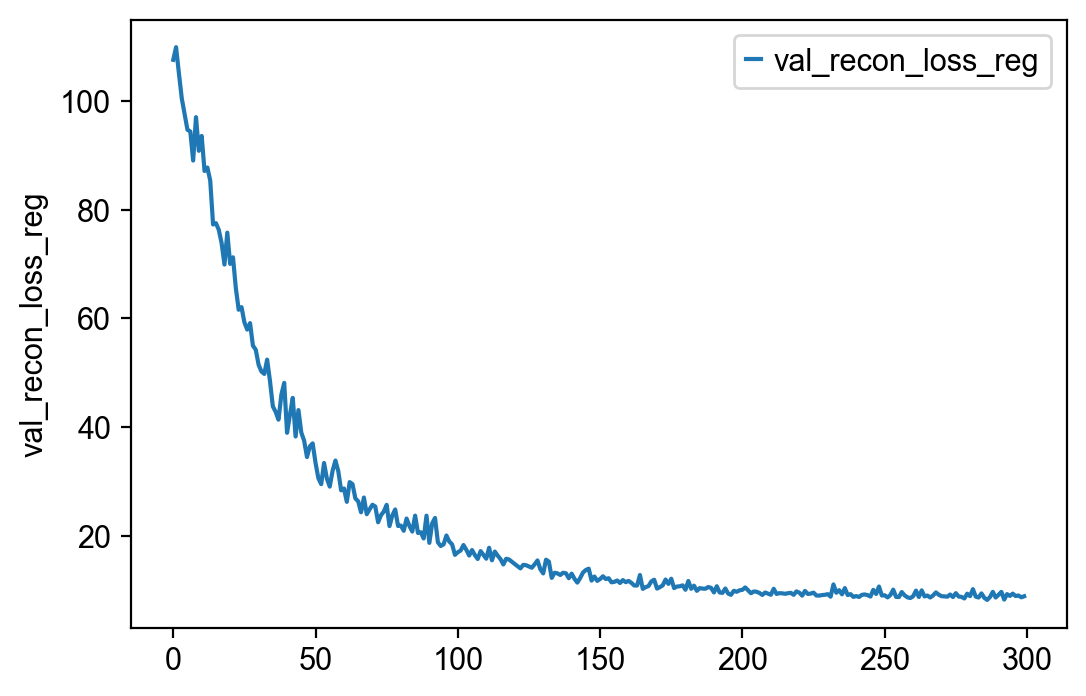

In [24]:
rgv_m.log['val_kl_div']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['val_recon_loss_target'], label="val_recon_loss_reg")
ax.set_ylabel("val_recon_loss_reg")
ax.legend()
plt.show()

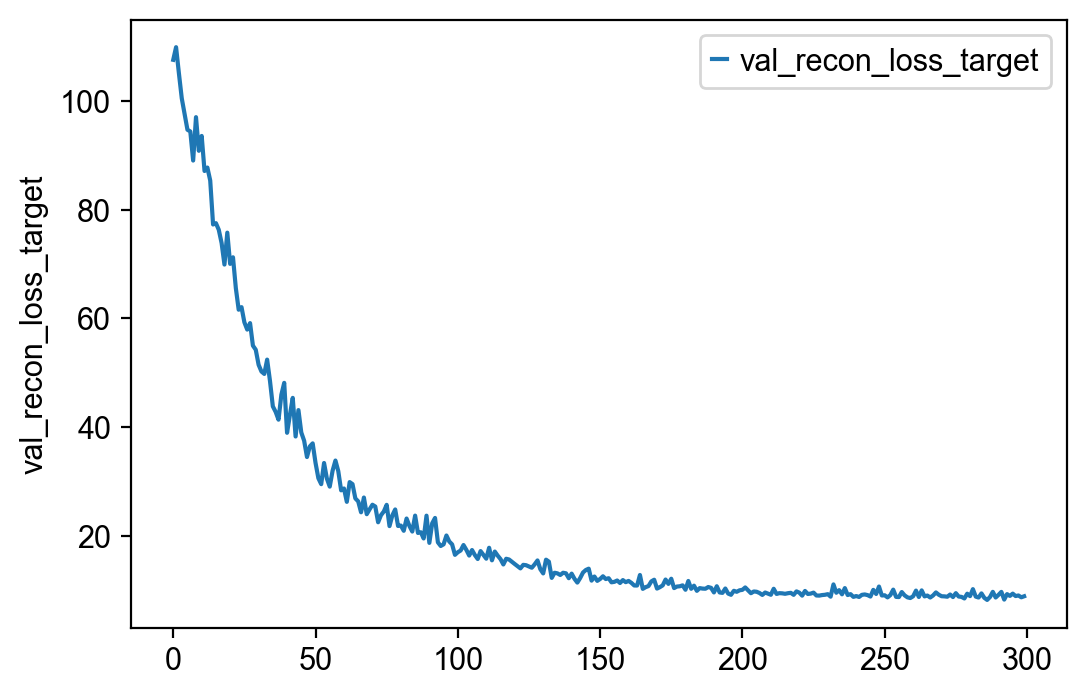

In [25]:
rgv_m.log['val_recon_loss_target']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['val_recon_loss_target'], label="val_recon_loss_target")
ax.set_ylabel("val_recon_loss_target")
ax.legend()
plt.show()

In [26]:
from torch.distributions import Normal
import torch.nn.functional as F
import torchode as to
def get_time_and_velocity(adata_raw, self,n_samples = 1, sim_dynamics = False) -> np.ndarray:
        """
        Get the developmental pseudotime for all cells.

        Returns
        ----------
        :class:`~numpy.ndarray`
            The estimated pseudotime of cells.
        """

        self.model.eval()
        ### processing adata
        adata = adata_raw.copy()
        target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        adata = adata[:,target_index]
        
        ### compute latent time
        X = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
        X = torch.tensor(X).to(self.device)
        #ts, _, _ = self.model.encoder(X)
        qz_m, qz_v, z = self.model.z_encoder(X)
        T = self.model.decoder(z).sigmoid() * 20
        
        if n_samples > 1:
            qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
            qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
            # when z is normal, untran_z == z
            untran_z = Normal(qz_m, qz_v.sqrt()).sample()
            z = self.model.z_encoder.z_transformation(untran_z)
            T = self.model.decoder(z).sigmoid() * 20
            T = T.mean(0)
        
        latent_time = T
        col_min = torch.min(latent_time, dim=0)[0]
        col_max = torch.max(latent_time, dim=0)[0]
        # perform min-max scaling on each column
        #latent_time = (latent_time - col_min) / (col_max - col_min)
        latent_time = latent_time.detach().numpy()
        scaling = 20 / (latent_time.max(0) - latent_time.min(0))
        latent_time = (latent_time - col_min.detach().numpy()) / (col_max.detach().numpy() - col_min.detach().numpy())
        #latent_time = latent_time*scaling[np.newaxis, :]
        
        #latent_time = latent_time.detach().numpy()
        #scaling = 20 / latent_time.max(0)

        adata.layers["fit_t"] = latent_time
        
        ### compute velocity    
        if sim_dynamics:
            unspliced = torch.tensor(adata.uns["Mu"].T).to(self.device)
            spliced = torch.tensor(adata.uns["Ms"].T).to(self.device)
            ## split spliced matrix into regulator spliced and target spliced
            regulator_spliced = spliced[self.model.regulator_index,:]
            target_spliced = spliced[self.model.target_index,:]
            target_unspliced = unspliced[self.model.target_index,:]
            
            T = T.T
            ## T is a N*G matrix (G:number of target gene, N:number of cells)
            ## ordering each raw of T
            indices = torch.argsort(T, dim=1)

            t_eval = torch.gather(T, dim = 1, index = indices)
            target_spliced = torch.gather(target_spliced, dim = 1, index = indices)
            target_unspliced = torch.gather(target_unspliced, dim = 1, index = indices)
            
            index2 = (t_eval[:,:-1] != t_eval[:,1:])
            ## estimate the shift value
            subtraction_values,_ = torch.where((t_eval[:,1:] - t_eval[:,:-1])>0, (t_eval[:,1:] - t_eval[:,:-1]), torch.inf).min(axis=1)
            ## replace inf value = 0
            subtraction_values[subtraction_values == float("Inf")] = 0

            true_tensor = torch.ones((t_eval.shape[0],1), dtype=torch.bool)
            index2 = torch.cat((index2, true_tensor.to(index2.device)),dim=1) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
            
            subtraction_values = subtraction_values[None, :].repeat(index2.shape[1], 1).T
            t_eval[index2 == False] -= subtraction_values[index2 == False]*0.1
            ## extract initial target gene expression value
            x0 = torch.cat((target_unspliced[:,0].reshape((target_unspliced.shape[0],1)),target_spliced[:,0].reshape((target_spliced.shape[0],1))),dim = 1)
            #x0 = x0.double()
            ## set up G batches, Each G represent a module (a target gene centerred regulon)
            ## infer the observe gene expression through ODE solver based on x0, t, and velocity_encoder
            #indices = torch.arange(0, x0.shape[0]).reshape((x0.shape[0],1))

            term = to.ODETerm(self.model.v_encoder)
            step_method = to.Dopri5(term=term)
            #step_size_controller = to.IntegralController(atol=1e-6, rtol=1e-3, term=term)
            step_size_controller = to.FixedStepController()
            solver = to.AutoDiffAdjoint(step_method, step_size_controller)
            #jit_solver = torch.jit.script(solver)
            dt0 = torch.full((x0.shape[0],), 1)
            sol = solver.solve(to.InitialValueProblem(y0=x0, t_eval=t_eval),dt0=dt0)
            
            # the solved results are saved in sol.ys [the number of subsystems, time_stamps, [u,s]]
            pred_u = sol.ys[:,:,0]
            pred_s = sol.ys[:,:,1]
        
            unspliced = torch.zeros_like(pred_u)
            unspliced.scatter_(1, indices, pred_u)
            spliced = torch.zeros_like(pred_s)
            spliced.scatter_(1, indices, pred_s)
            unspliced = unspliced.detach().numpy().T
            spliced = spliced.detach().numpy().T
        else:
            unspliced = adata.layers["Mu"]
            spliced = adata.layers["Ms"]
            
        beta = torch.clamp(F.softplus(self.model.v_encoder.beta_mean_unconstr), 0, 50)
        gamma = torch.clamp(F.softplus(self.model.v_encoder.gamma_mean_unconstr), 0, 50)  
        velocity = unspliced*beta.detach().numpy() - spliced*gamma.detach().numpy()
        
        adata.layers["velocity"] = velocity / scaling
        
        return adata

In [27]:
sum(rgv_m.model.target_index)

133

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


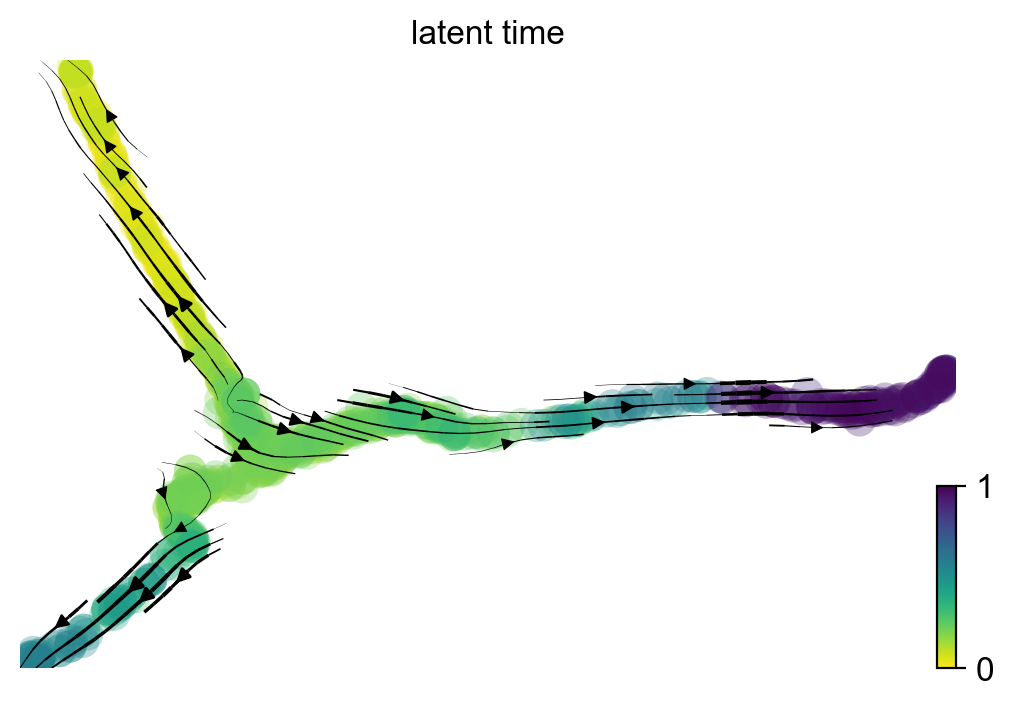

In [28]:
adata_target = get_time_and_velocity(adata,rgv_m,n_samples = 25,sim_dynamics = True)
scv.tl.velocity_graph(adata_target)
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [34]:
from torch.distributions import Normal
import torch.nn.functional as F
import torchode as to
def get_pre_readout(adata_raw, self,n_samples = 1, sim_dynamics = False) -> np.ndarray:
        """
        Get the developmental pseudotime for all cells.

        Returns
        ----------
        :class:`~numpy.ndarray`
            The estimated pseudotime of cells.
        """

        self.model.eval()
        ### processing adata
        adata = adata_raw.copy()
        target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        adata = adata[:,target_index]
        
        ### compute latent time
        X = np.concatenate([adata_raw.layers["Mu"],adata_raw.layers["Ms"]],axis = 1)
        X = torch.tensor(X).to(self.device)
        #ts, _, _ = self.model.encoder(X)
        qz_m, qz_v, z = self.model.z_encoder(X)
        T = self.model.decoder(z).sigmoid() * 20
        
        if n_samples > 1:
            qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
            qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
            # when z is normal, untran_z == z
            untran_z = Normal(qz_m, qz_v.sqrt()).sample()
            z = self.model.z_encoder.z_transformation(untran_z)
            T = self.model.decoder(z).sigmoid() * 20
            T = T.mean(0)
        
        latent_time = T
        col_min = torch.min(latent_time, dim=0)[0]
        col_max = torch.max(latent_time, dim=0)[0]
        # perform min-max scaling on each column
        #latent_time = (latent_time - col_min) / (col_max - col_min)
        latent_time = latent_time.detach().numpy()
        scaling = 20 / (latent_time.max(0) - latent_time.min(0))
        latent_time = (latent_time - col_min.detach().numpy()) / (col_max.detach().numpy() - col_min.detach().numpy())
        #latent_time = latent_time*scaling[np.newaxis, :]
        
        #latent_time = latent_time.detach().numpy()
        #scaling = 20 / latent_time.max(0)

        adata.layers["fit_t"] = latent_time
        
        ### compute velocity    
        if sim_dynamics:
            unspliced = torch.tensor(adata.uns["Mu"].T).to(self.device)
            spliced = torch.tensor(adata.uns["Ms"].T).to(self.device)
            ## split spliced matrix into regulator spliced and target spliced
            regulator_spliced = spliced[self.model.regulator_index,:]
            target_spliced = spliced[self.model.target_index,:]
            target_unspliced = unspliced[self.model.target_index,:]
            
            T = T.T
            ## T is a N*G matrix (G:number of target gene, N:number of cells)
            ## ordering each raw of T
            indices = torch.argsort(T, dim=1)

            t_eval = torch.gather(T, dim = 1, index = indices)
            target_spliced = torch.gather(target_spliced, dim = 1, index = indices)
            target_unspliced = torch.gather(target_unspliced, dim = 1, index = indices)
            
            index2 = (t_eval[:,:-1] != t_eval[:,1:])
            ## estimate the shift value
            subtraction_values,_ = torch.where((t_eval[:,1:] - t_eval[:,:-1])>0, (t_eval[:,1:] - t_eval[:,:-1]), torch.inf).min(axis=1)
            ## replace inf value = 0
            subtraction_values[subtraction_values == float("Inf")] = 0

            true_tensor = torch.ones((t_eval.shape[0],1), dtype=torch.bool)
            index2 = torch.cat((index2, true_tensor.to(index2.device)),dim=1) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
            
            subtraction_values = subtraction_values[None, :].repeat(index2.shape[1], 1).T
            t_eval[index2 == False] -= subtraction_values[index2 == False]*0.1
            ## extract initial target gene expression value
            x0 = torch.cat((target_unspliced[:,0].reshape((target_unspliced.shape[0],1)),target_spliced[:,0].reshape((target_spliced.shape[0],1))),dim = 1)
            #x0 = x0.double()
            ## set up G batches, Each G represent a module (a target gene centerred regulon)
            ## infer the observe gene expression through ODE solver based on x0, t, and velocity_encoder
            #indices = torch.arange(0, x0.shape[0]).reshape((x0.shape[0],1))

            term = to.ODETerm(self.model.v_encoder)
            step_method = to.Dopri5(term=term)
            #step_size_controller = to.IntegralController(atol=1e-6, rtol=1e-3, term=term)
            step_size_controller = to.FixedStepController()
            solver = to.AutoDiffAdjoint(step_method, step_size_controller)
            #jit_solver = torch.jit.script(solver)
            dt0 = torch.full((x0.shape[0],), 1)
            sol = solver.solve(to.InitialValueProblem(y0=x0, t_eval=t_eval),dt0=dt0)
            
            # the solved results are saved in sol.ys [the number of subsystems, time_stamps, [u,s]]
            pred_u = sol.ys[:,:,0]
            pred_s = sol.ys[:,:,1]
        
            unspliced = torch.zeros_like(pred_u)
            unspliced.scatter_(1, indices, pred_u)
            spliced = torch.zeros_like(pred_s)
            spliced.scatter_(1, indices, pred_s)
            unspliced = unspliced.detach().numpy().T
            spliced = spliced.detach().numpy().T
        else:
            unspliced = adata.layers["Mu"]
            spliced = adata.layers["Ms"]
            
        
        return unspliced,spliced

In [62]:
pre_u,pre_s = get_pre_readout(adata,rgv_m,n_samples = 25,sim_dynamics = True)

In [63]:
import sklearn
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,target_index],pre_s))
rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,target_index],pre_u))

In [64]:
(rmse_s+rmse_u)/2

0.28278881311416626

In [119]:
adata_kfold = adata.copy()

### calculate K-fold test reconstruction error

In [68]:
import sklearn
from sklearn.model_selection import KFold

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

test_rmse = []
for fold,(train_ids, test_ids) in enumerate(kfold.split(adata_kfold.layers["Ms"])):
    adata_train = adata[train_ids].copy()
    adata_test = adata[test_ids].copy()
    rgv_m = rgv.train.Trainer(adata_train, W=W.T,early_stopping = True, nepoch = 300, solver = "AdaBelief", lr = 0.0001,T_max = 300,batch_size=256,grad_clip = 5,mac_user = False)
    rgv_m.model.dt0 = torch.full((rgv_m.model.n_targets,), 1)
    rgv_m.train()
    pre_u,pre_s = get_pre_readout(adata_test,rgv_m,n_samples = 25,sim_dynamics = True)

    target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
    rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Ms"][:,target_index],pre_s))
    rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Mu"][:,target_index],pre_u))
    test_rmse.append((rmse_s+rmse_u)/2)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 300: 100%|████████████████████████████████████████| 300/300 [02:32<00:00,  1.97epoch/s, train_loss=71, val_loss=23.7]


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 284:  95%|███████████████████████████████████▉  | 284/300 [02:33<00:08,  1.84epoch/s, train_loss=70.6, val_loss=25.9]


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 247:  82%|███████████████████████████████▎      | 247/300 [02:09<00:27,  1.90epoch/s, train_loss=71.4, val_loss=27.7]


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 300: 100%|██████████████████████████████████████| 300/300 [02:32<00:00,  1.96epoch/s, train_loss=70.7, val_loss=21.9]


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Epoch 300: 100%|██████████████████████████████████████| 300/300 [02:33<00:00,  1.96epoch/s, train_loss=71.4, val_loss=24.1]


In [73]:
test_rmse_regvelo_decouple = test_rmse.copy()

In [74]:
np.mean(test_rmse_regvelo_decouple)

0.29798481464385984

In [120]:
######## running coupling model
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import RegVelo as rgv

In [121]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [122]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [123]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [124]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=210)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 210 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [125]:
adata.X = np.log1p(adata.X.copy())
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [126]:
W = adata.uns["skeleton"].copy()

In [127]:
features = [i in adata.var.index.values for i in adata.uns["regulators"]]
W = W[features,:]
W = W[:,features]

In [128]:
import torch
W = torch.tensor(W).int()

In [85]:
rgv_m = rgv.train.Trainer(adata, loss_mode='mse',W=W.T, solver = "AdamW",early_stopping = False, scheduler = "CyclicLR", batch_size = 128,nepoch = 500, n_latent = 20,lr = 0.01,wt_decay = 0.01)

In [86]:
rgv_m.train()

Epoch 500: 100%|██████████████████████████████████████| 500/500 [02:00<00:00,  4.14epoch/s, train_loss=14.5, val_loss=13.9]


In [87]:
adata.obs["sim_time"]

cell1         0.000000
cell2        78.083333
cell3       372.083333
cell4       172.000000
cell5        92.083333
               ...    
cell996     348.083333
cell997      26.083333
cell998      10.000000
cell999      34.083333
cell1000    390.083333
Name: sim_time, Length: 1000, dtype: float64

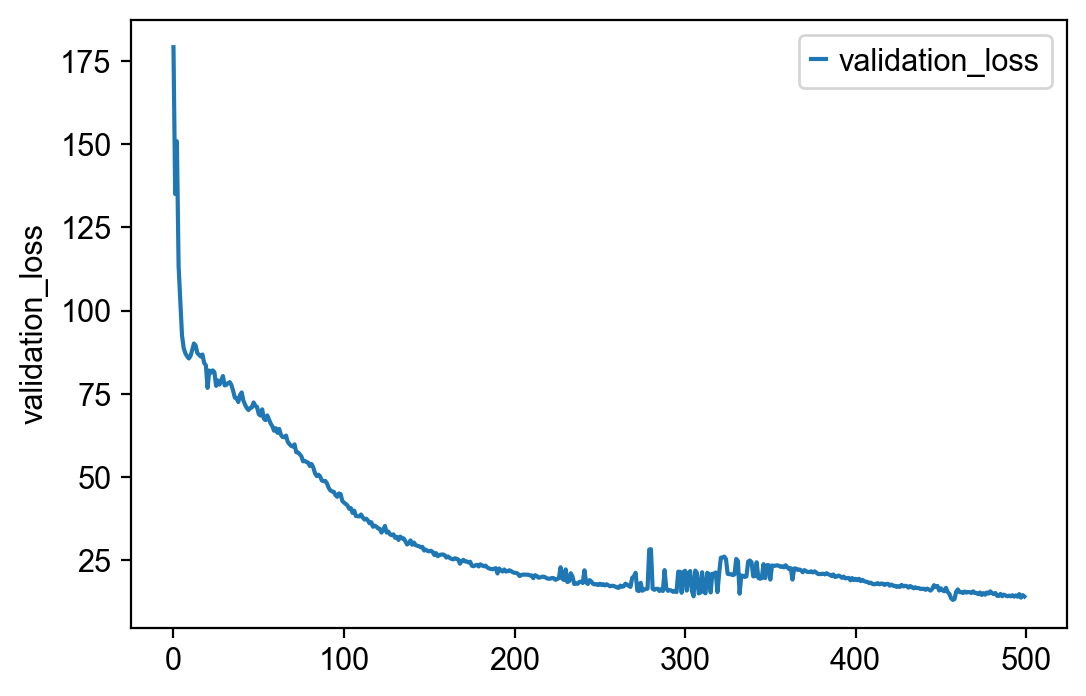

In [88]:
rgv_m.log['validation_loss']
fig, ax = plt.subplots()
ax.plot(rgv_m.log['validation_loss'], label="validation_loss")
ax.set_ylabel("validation_loss")
ax.legend()
plt.show()

In [89]:
from typing import Optional
from sctour._utils import get_step_size
from torchdiffeq import odeint
def get_vector_field(
    self,
    T: np.ndarray,
    model: Optional[str] = None,
    sim_dynamics: bool = False,
) -> np.ndarray:
    """
    Get the vector field.

    Parameters
    ----------
    T
        The estimated pseudotime for each cell.
    Z
        The latent representation for each cell.
    model
        The model used to get the vector field. Only provided when using the saved model.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated vector field.
    """

    model = self._get_model(model)
    model.eval()
    Z = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    if not (isinstance(T, np.ndarray) and isinstance(Z, np.ndarray)):
        raise TypeError('The inputs must be numpy arrays.')
    Z = torch.tensor(Z).to(self.device)
    T = torch.tensor(T).to(self.device)
    #index = torch.argsort(T)
    #T = T[index]
    #Z = Z[index]

    #if self.time_reverse is None:
    #    raise RuntimeError('It seems you did not run get_time() function first. Please run get_time() before you run get_vector_field().')
    #direction = 1
    #if self.time_reverse:
    #    direction = -1
    velo = model.lode_func(T, Z).cpu().detach().numpy()

    if sim_dynamics:
        id = adata.obs.index.values
        ## simulate the system to generate the dynamics of all cells
        T = T.ravel()  ## odeint requires 1-D Tensor for time
        index = torch.argsort(T)
        T = T[index]
        Z = Z[index]
        id = id[index.cpu().numpy()]
        index2 = (T[:-1] != T[1:])
        index2 = torch.cat((index2, torch.tensor([True]).to(index2.device))) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
        T = T[index2]   
        Z = Z[index2]
        id = id[index2.cpu().numpy()]

        ## generate dynamics through ODE solver
        Z0 = Z[0]
        options = get_step_size(model.step_size, T[0], T[-1], len(T))
        pred_x = odeint(model.lode_func, Z0.to(model.device), T.to(model.device), method = model.ode_method, options = options).view(-1, model.n_int)
        pred_x = pred_x.to(Z.device)
        
        new_velo = model.lode_func(T, pred_x).cpu().detach().numpy()
        
        ## insert into the velocity matrix
        insert = [adata.obs.index.tolist().index(i) for i in id]
        for i in insert:
            velo[i,:] = new_velo[i,:]

    return velo

In [90]:
adata.obs["ptime"] = rgv_m.get_time()
velocity = get_vector_field(rgv_m,T=adata.obs['ptime'].values)
adata.obs["ptime"] = (adata.obs["ptime"] - adata.obs["ptime"].min()) / (adata.obs["ptime"].max() - adata.obs["ptime"].min())

In [91]:
velocity = torch.tensor(velocity)

In [92]:
ds = velocity[:,int(rgv_m.n_int/2):rgv_m.n_int]

In [93]:
ds.shape

torch.Size([1000, 142])

In [94]:
adata.layers["velocity"] = ds

In [95]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


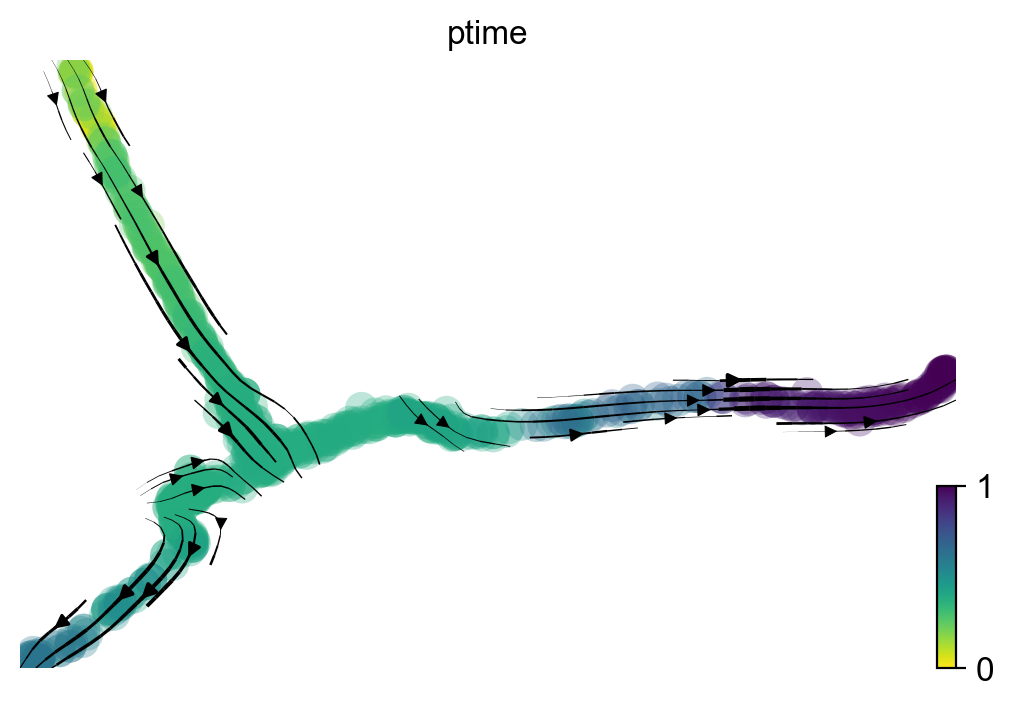

In [96]:
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'ptime')

In [132]:

def get_pre_readout(
    self,
    Ms,
    Mu,
    T: np.ndarray,
    model: Optional[str] = None,
    sim_dynamics: bool = False,
) -> np.ndarray:
    """
    Get the vector field.

    Parameters
    ----------
    T
        The estimated pseudotime for each cell.
    Z
        The latent representation for each cell.
    model
        The model used to get the vector field. Only provided when using the saved model.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated vector field.
    """

    model = self._get_model(model)
    model.eval()
    Z = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    if not (isinstance(T, np.ndarray) and isinstance(Z, np.ndarray)):
        raise TypeError('The inputs must be numpy arrays.')
    Z = torch.tensor(Z).to(self.device)
    T = torch.tensor(T).to(self.device)
    #index = torch.argsort(T)
    #T = T[index]
    #Z = Z[index]

    #if self.time_reverse is None:
    #    raise RuntimeError('It seems you did not run get_time() function first. Please run get_time() before you run get_vector_field().')
    #direction = 1
    #if self.time_reverse:
    #    direction = -1
    velo = model.lode_func(T, Z).cpu().detach().numpy()

    if sim_dynamics:
        id = adata.obs.index.values
        ## simulate the system to generate the dynamics of all cells
        T = T.ravel()  ## odeint requires 1-D Tensor for time
        index = torch.argsort(T)
        T = T[index]
        Z = Z[index]
        Ms = Ms[index]
        Mu = Mu[index]
        id = id[index.cpu().numpy()]
        index2 = (T[:-1] != T[1:])
        index2 = torch.cat((index2, torch.tensor([True]).to(index2.device))) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
        T = T[index2]   
        Z = Z[index2]
        Ms = Ms[index2]
        Mu = Mu[index2]
        id = id[index2.cpu().numpy()]

        ## generate dynamics through ODE solver
        Z0 = Z[0]
        options = get_step_size(model.step_size, T[0], T[-1], len(T))
        pred_x = odeint(model.lode_func, Z0.to(model.device), T.to(model.device), method = model.ode_method, options = options).view(-1, model.n_int)
        pred_x = pred_x.to(Z.device)
        
        pred_x = pred_x.detach().numpy()

    return pred_x,Ms,Mu

def get_time(self,adata_raw) -> np.ndarray:
    """
    Get the developmental pseudotime for all cells.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated pseudotime of cells.
    """

    self.model.eval()
    X = np.concatenate([adata_raw.layers["Mu"],adata_raw.layers["Ms"]],axis = 1)
    X = torch.tensor(X).to(self.device)
    #ts, _, _ = self.model.encoder(X)
    qz_m, _ = self.model.encoder(X)
    ts = self.model.t_encoder(qz_m).sigmoid() * 20
    ts = ts.ravel()

    ## The model might return reversed time. Check this based on number of genes expressed in cells
    #if self.time_reverse is None:
    #    n_genes = torch.tensor(self.adata.obs['n_genes_by_counts'].values).float().log1p().to(self.device)
    #    m_ts = ts.mean()
    #    m_ngenes = n_genes.mean()
    #    beta_direction = (ts * n_genes).sum() - len(ts) * m_ts * m_ngenes
    #    if beta_direction > 0:
    #        self.time_reverse = True
    #    else:
    #        self.time_reverse = False
    #if self.time_reverse:
    #    ts = 1 - ts

    return ts.cpu().detach().numpy()

In [98]:
pre_u_s,Ms,Mu = get_pre_readout(rgv_m,adata.layers["Ms"],adata.layers["Mu"],T=adata.obs['ptime'].values,sim_dynamics=True)

In [99]:
pre_u = pre_u_s[:,:142].copy()
pre_s = pre_u_s[:,142:].copy()

In [100]:
import sklearn
rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(Ms,pre_s))
rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(Mu,pre_u))

In [101]:
(rmse_s+rmse_u)/2

0.24141539633274078

In [134]:
test_rmse = []
for fold,(train_ids, test_ids) in enumerate(kfold.split(adata_kfold.layers["Ms"])):
    adata_train = adata[train_ids].copy()
    adata_test = adata[test_ids].copy()
    rgv_m = rgv.train.Trainer(adata, loss_mode='mse',W=W.T, solver = "AdamW",early_stopping = False, scheduler = "CyclicLR", batch_size = 128,nepoch = 500, n_latent = 20,lr = 0.01,wt_decay = 0.01)
    rgv_m.train()
    adata_test.obs["ptime"] = get_time(rgv_m,adata_test)
    pre_u_s,Ms,Mu = get_pre_readout(rgv_m,adata_test.layers["Ms"],adata_test.layers["Mu"],T=adata_test.obs['ptime'].values,sim_dynamics=True)
    pre_u = pre_u_s[:,:142].copy()
    pre_s = pre_u_s[:,142:].copy()
    rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(Ms,pre_s))
    rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(Mu,pre_u))
    test_rmse.append((rmse_s+rmse_u)/2)

Epoch 500: 100%|██████████████████████████████████████| 500/500 [02:00<00:00,  4.15epoch/s, train_loss=14.5, val_loss=13.9]


In [151]:
test_rmse_regvelo_global = test_rmse.copy()

In [152]:
np.mean(test_rmse_regvelo_global)

0.4473387122154236

In [153]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [154]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [155]:
adata.uns["skeleton"].shape

(280, 280)

In [156]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [157]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [158]:
adata.layers["Ms"].max()

39747.324

In [159]:
adata.X = np.log1p(adata.X.copy())

In [160]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133


In [161]:
adata.uns["Ms"].max()

1.0000001

In [162]:
adata.uns["skeleton"].shape

(88, 133)

In [163]:
adata.layers["Mu"]

array([[2.2237231e-01, 4.7074676e-01, 4.6435753e-01, ..., 3.5754797e-01,
        5.8896059e-01, 5.5074126e-01],
       [3.9832376e-02, 3.7840270e-02, 9.4398372e-02, ..., 6.6738677e-01,
        4.4496155e-01, 5.8145988e-01],
       [2.0395366e-04, 0.0000000e+00, 0.0000000e+00, ..., 5.2545571e-01,
        3.2124108e-01, 4.0531948e-01],
       ...,
       [7.1582097e-01, 8.1019086e-01, 6.7791092e-01, ..., 1.7445381e-01,
        5.2486598e-01, 5.0284755e-01],
       [1.3497818e-03, 8.5646566e-03, 4.5474763e-03, ..., 6.9176316e-01,
        5.2862996e-01, 5.1687372e-01],
       [5.7561410e-04, 0.0000000e+00, 0.0000000e+00, ..., 5.7540834e-01,
        1.7816161e-01, 9.6220253e-03]], dtype=float32)

In [164]:
W = adata.uns["skeleton"].copy()

In [165]:
import torch
W = torch.tensor(np.array(W)).int()

In [166]:
W.shape

torch.Size([88, 133])

In [167]:
from velovi import preprocess_data, VELOVI
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:24<00:00,  5.84it/s, loss=-674, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:24<00:00,  5.89it/s, loss=-674, v_num=1]


In [253]:
import logging
import warnings
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union
from anndata import AnnData
import torch.nn.functional as F

def get_pre_readout(
        self,
        adata: Optional[AnnData] = None,
        indices: Optional[Sequence[int]] = None,
        gene_list: Optional[Sequence[str]] = None,
        n_samples: int = 1,
        n_samples_overall: Optional[int] = None,
        batch_size: Optional[int] = None,
        return_mean: bool = True,
        return_numpy: Optional[bool] = None,
        velo_statistic: str = "mean",
        velo_mode: Literal["spliced", "unspliced"] = "spliced",
        clip: bool = True,
    ) -> Union[np.ndarray, pd.DataFrame]:
        """Returns cells by genes velocity estimates.

        Parameters
        ----------
        adata
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model.
        indices
            Indices of cells in adata to use. If `None`, all cells are used.
        gene_list
            Return velocities for a subset of genes.
            This can save memory when working with large datasets and few genes are
            of interest.
        n_samples
            Number of posterior samples to use for estimation for each cell.
        n_samples_overall
            Number of overall samples to return. Setting this forces n_samples=1.
        batch_size
            Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
        return_mean
            Whether to return the mean of the samples.
        return_numpy
            Return a :class:`~numpy.ndarray` instead of a :class:`~pandas.DataFrame`. DataFrame includes
            gene names as columns. If either `n_samples=1` or `return_mean=True`, defaults to `False`.
            Otherwise, it defaults to `True`.
        velo_statistic
            Whether to compute expected velocity over states, or maximum a posteriori velocity over maximal
            probability state.
        velo_mode
            Compute ds/dt or du/dt.
        clip
            Clip to minus spliced value

        Returns
        -------
        If `n_samples` > 1 and `return_mean` is False, then the shape is `(samples, cells, genes)`.
        Otherwise, shape is `(cells, genes)`. In this case, return type is :class:`~pandas.DataFrame` unless `return_numpy` is True.
        """
        adata = self._validate_anndata(adata)
        if indices is None:
            indices = np.arange(adata.n_obs)
        if n_samples_overall is not None:
            indices = np.random.choice(indices, n_samples_overall)
            n_samples = 1
        scdl = self._make_data_loader(
            adata=adata, indices=indices, batch_size=batch_size
        )

        if gene_list is None:
            gene_mask = slice(None)
        else:
            all_genes = adata.var_names
            gene_mask = [True if gene in gene_list else False for gene in all_genes]

        if n_samples > 1 and return_mean is False:
            if return_numpy is False:
                warnings.warn(
                    "return_numpy must be True if n_samples > 1 and return_mean is False, returning np.ndarray"
                )
            return_numpy = True
        if indices is None:
            indices = np.arange(adata.n_obs)

        pre_u_all = []
        pre_s_all = []
        for tensors in scdl:
            minibatch_samples_u = []
            minibatch_samples_s = []
            for _ in range(n_samples):
                inference_outputs, generative_outputs = self.module.forward(
                    tensors=tensors,
                    compute_loss=False,
                )
                pi = generative_outputs["px_pi"]
                alpha = inference_outputs["alpha"]
                alpha_1 = inference_outputs["alpha_1"]
                lambda_alpha = inference_outputs["lambda_alpha"]
                beta = inference_outputs["beta"]
                gamma = inference_outputs["gamma"]
                tau = generative_outputs["px_tau"]
                rho = generative_outputs["px_rho"]

                ind_prob = pi[..., 0]
                steady_prob = pi[..., 1]
                rep_prob = pi[..., 2]
                switch_time = F.softplus(self.module.switch_time_unconstr)

                ind_time = switch_time * rho
                u_0, s_0 = self.module._get_induction_unspliced_spliced(
                    alpha, alpha_1, lambda_alpha, beta, gamma, switch_time
                )
                rep_time = (self.module.t_max - switch_time) * tau
                mean_u_rep, mean_s_rep = self.module._get_repression_unspliced_spliced(
                    u_0,
                    s_0,
                    beta,
                    gamma,
                    rep_time,
                )
                
                mean_u_ind, mean_s_ind = self.module._get_induction_unspliced_spliced(
                    alpha, alpha_1, lambda_alpha, beta, gamma, ind_time
                )

                # expectation
                if velo_statistic == "mean":
                    pre_u = (
                        ind_prob * mean_u_ind
                        + rep_prob * mean_u_rep
                    )
                    pre_s = (
                        ind_prob * mean_s_ind
                        + rep_prob * mean_s_rep
                    )
                # maximum
                else:
                    v = torch.stack(
                        [
                            velo_ind,
                            velo_steady.expand(velo_ind.shape),
                            velo_rep,
                            torch.zeros_like(velo_rep),
                        ],
                        dim=2,
                    )
                    max_prob = torch.amax(pi, dim=-1)
                    max_prob = torch.stack([max_prob] * 4, dim=2)
                    max_prob_mask = pi.ge(max_prob)
                    output = (v * max_prob_mask).sum(dim=-1)

                pre_u = pre_u[..., gene_mask]
                pre_u = pre_u.detach().cpu().numpy()
                pre_s = pre_s[..., gene_mask]
                pre_s = pre_s.detach().cpu().numpy()
                minibatch_samples_u.append(pre_u)
                minibatch_samples_s.append(pre_s)
            # samples by cells by genes
            pre_u_all.append(np.stack(minibatch_samples_u, axis=0))
            pre_s_all.append(np.stack(minibatch_samples_s, axis=0))
            if return_mean:
                # mean over samples axis
                pre_u_all[-1] = np.mean(pre_u_all[-1], axis=0)
                pre_s_all[-1] = np.mean(pre_s_all[-1], axis=0)

        if n_samples > 1:
            # The -2 axis correspond to cells.
            pre_u_all = np.concatenate(pre_u_all, axis=-2)
            pre_s_all = np.concatenate(pre_s_all, axis=-2)
        else:
            pre_u_all = np.concatenate(pre_u_all, axis=0)
            pre_s_all = np.concatenate(pre_s_all, axis=0)

        return pre_u_all,pre_s_all

In [172]:
pre_u, pre_s = get_pre_readout(vae,adata,n_samples=25, velo_statistic="mean")

In [173]:
import sklearn
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"],pre_s))
rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"],pre_u))

In [174]:
(rmse_s+rmse_u)/2

0.1456432342529297

In [175]:
test_rmse = []
for fold,(train_ids, test_ids) in enumerate(kfold.split(adata_kfold.layers["Ms"])):
    adata_train = adata[train_ids].copy()
    adata_test = adata[test_ids].copy()
    VELOVI.setup_anndata(adata_train, spliced_layer="Ms", unspliced_layer="Mu")
    vae = VELOVI(adata_train)
    vae.train()
    pre_u, pre_s = get_pre_readout(vae,adata_test,n_samples=25, velo_statistic="mean")
    
    target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
    rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Ms"],pre_s))
    rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Mu"],pre_u))
    test_rmse.append((rmse_s+rmse_u)/2)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.38it/s, loss=-655, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.33it/s, loss=-655, v_num=1]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.15it/s, loss=-658, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.26it/s, loss=-658, v_num=1]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:09<00:00,  6.98it/s, loss=-660, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.18it/s, loss=-660, v_num=1]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:10<00:00,  6.93it/s, loss=-662, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.12it/s, loss=-662, v_num=1]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:10<00:00,  6.82it/s, loss=-663, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.13it/s, loss=-663, v_num=1]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [254]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.X = np.log1p(adata.X.copy())

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [255]:
test_rmse = []
for fold,(train_ids, test_ids) in enumerate(kfold.split(adata_kfold.layers["Ms"])):
    adata_train = adata[train_ids].copy()
    adata_test = adata[test_ids].copy()
    adata_train,scalar = preprocess_data(adata_train)
    
    adata_test.layers["Mu"] = scaler.transform(adata_test.layers["Mu"]).copy()
    adata_test.layers["Ms"] = scaler.transform(adata_test.layers["Ms"]).copy()
    adata_test = adata_test[:,adata_train.var.index.values]
    
    VELOVI.setup_anndata(adata_train, spliced_layer="Ms", unspliced_layer="Mu")
    vae = VELOVI(adata_train)
    vae.train()
    pre_u, pre_s = get_pre_readout(vae,adata_test,n_samples=25, velo_statistic="mean")
    
    target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
    rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Ms"],pre_s))
    rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Mu"],pre_u))
    test_rmse.append((rmse_s+rmse_u)/2)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.80it/s, loss=-720, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.69it/s, loss=-720, v_num=1]
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.34it/s, loss=-720, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.78it/s, loss=-720, v_num=1]
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.91it/s, loss=-724, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.81it/s, loss=-724, v_num=1]
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.37it/s, loss=-728, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.71it/s, loss=-728, v_num=1]
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.68it/s, loss=-725, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.70it/s, loss=-725, v_num=1]
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [259]:
adata_train

AnnData object with n_obs × n_vars = 800 × 160
    obs: 'step_ix', 'simulation_i', 'sim_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'network', 'regulators', 'skeleton', 'targets', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca', 'neighbors', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'dimred', 'X_pca'
    varm: 'PCs'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts', 'rna_velocity', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [179]:
test_rmse_velovi = test_rmse.copy()

In [4]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [5]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [6]:
adata.uns["skeleton"].shape

(280, 280)

In [7]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
adata.layers["Ms"].max()

39747.324

In [10]:
adata.X = np.log1p(adata.X.copy())

In [11]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133


In [267]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [268]:
W = torch.ones(W.shape)

In [173]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae_0 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0)
reg_vae_0_0001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.0001)
reg_vae_0_001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.001)
reg_vae_0_01 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.01)
reg_vae_0_1 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.1)

In [167]:
reg_vae.module.RBF_interpolate

True

In [174]:
reg_vae_0.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_0001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_01.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_1.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [175]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [176]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([ 0.3319,  0.3022,  0.4831, -0.0287,  0.3441,  0.2803,  0.3116,  0.4592,
         0.6171,  0.8150,  0.8910,  0.6375,  0.8970,  0.6178,  0.9746,  1.1121,
         0.7802,  0.9664,  0.5805,  1.0388,  0.6448,  0.9083,  1.0867,  0.5530,
         0.9961,  0.6777,  0.9742,  0.7914,  1.0277,  0.9779,  0.5783,  0.4827,
         0.1347,  0.3294,  0.3218,  0.5410,  0.5851,  0.4669,  0.3932,  0.3966,
         0.4539,  0.3946,  0.4707,  0.4323,  0.3817,  0.3813,  0.4635,  0.3200,
         0.4409,  0.2711,  0.5072,  0.4604,  0.6922,  0.9387,  0.5103,  0.5899,
         0.5888,  0.8966,  0.5158,  0.5642,  0.5881,  0.6397,  0.6797,  0.2915,
         0.3712,  0.3848,  0.8247,  0.7216,  0.6880,  0.7154,  1.0002,  0.7245,
         0.7232,  0.8152,  0.7109,  0.4839,  0.8618,  0.7343,  0.6627,  0.6723,
         0.2304,  0.1366,  0.4493,  0.3007,  0.4725,  0.3076,  0.5333,  0.3527,
         0.8736,  0.4130,  0.9955,  0.5813,  0.6624,  0.8889,  0.9026,  0.8252,
         0.6680,  

In [177]:
reg_vae_0.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_0001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_01.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_1.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 607/1000:  61%|████████████████████████████▌                  | 607/1000 [09:00<05:49,  1.12it/s, loss=-562, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.312. Signaling Trainer to stop.
Epoch 486/1000:  49%|██████████████████████▊                        | 486/1000 [06:20<06:42,  1.28it/s, loss=-595, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.406. Signaling Trainer to stop.
Epoch 313/1000:  31%|██████████████▋                                | 313/1000 [04:08<09:05,  1.26it/s, loss=-565, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.290. Signaling Trainer to stop.
Epoch 188/1000:  19%|████████▊                                      | 188/1000 [02:29<10:45,  1.26it/s, loss=-528, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 252/1000:  25%|███████████▊                                   | 252/1000 [03:15<09:40,  1.29it/s, loss=-564, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.350. Signaling Trainer to stop.


In [201]:
import logging
import warnings
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union
from anndata import AnnData
import torch.nn.functional as F

def get_pred_readout(
    self,
    adata: Optional[AnnData] = None,
    indices: Optional[Sequence[int]] = None,
    gene_list: Optional[Sequence[str]] = None,
    n_samples: int = 1,
    n_samples_overall: Optional[int] = None,
    batch_size: Optional[int] = None,
    return_mean: bool = True,
    return_numpy: Optional[bool] = None,
    velo_statistic: str = "mean",
    velo_mode: Literal["spliced", "unspliced"] = "spliced",
    clip: bool = True,
) -> Union[np.ndarray, pd.DataFrame]:
    """Returns cells by genes velocity estimates.

    Parameters
    ----------
    adata
        AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
        AnnData object used to initialize the model.
    indices
        Indices of cells in adata to use. If `None`, all cells are used.
    gene_list
        Return velocities for a subset of genes.
        This can save memory when working with large datasets and few genes are
        of interest.
    n_samples
        Number of posterior samples to use for estimation for each cell.
    n_samples_overall
        Number of overall samples to return. Setting this forces n_samples=1.
    batch_size
        Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
    return_mean
        Whether to return the mean of the samples.
    return_numpy
        Return a :class:`~numpy.ndarray` instead of a :class:`~pandas.DataFrame`. DataFrame includes
        gene names as columns. If either `n_samples=1` or `return_mean=True`, defaults to `False`.
        Otherwise, it defaults to `True`.
    velo_statistic
        Whether to compute expected velocity over states, or maximum a posteriori velocity over maximal
        probability state.
    velo_mode
        Compute ds/dt or du/dt.
    clip
        Clip to minus spliced value

    Returns
    -------
    If `n_samples` > 1 and `return_mean` is False, then the shape is `(samples, cells, genes)`.
    Otherwise, shape is `(cells, genes)`. In this case, return type is :class:`~pandas.DataFrame` unless `return_numpy` is True.
    """
    adata = self._validate_anndata(adata)
    if indices is None:
        indices = np.arange(adata.n_obs)
    if n_samples_overall is not None:
        indices = np.random.choice(indices, n_samples_overall)
        n_samples = 1
    scdl = self._make_data_loader(
        adata=adata, indices=indices, batch_size=batch_size
    )

    if gene_list is None:
        gene_mask = slice(None)
    else:
        all_genes = adata.var_names
        gene_mask = [True if gene in gene_list else False for gene in all_genes]

    if n_samples > 1 and return_mean is False:
        if return_numpy is False:
            warnings.warn(
                "return_numpy must be True if n_samples > 1 and return_mean is False, returning np.ndarray"
            )
        return_numpy = True
    if indices is None:
        indices = np.arange(adata.n_obs)

    pre_u_all = []
    pre_s_all = []
    for tensors in scdl:
        minibatch_samples_u = []
        minibatch_samples_s = []
        for _ in range(n_samples):
            inference_outputs, generative_outputs = self.module.forward(
                tensors=tensors,
                compute_loss=False,
            )
            pi = generative_outputs["px_pi"]
            beta = inference_outputs["beta"]
            gamma = inference_outputs["gamma"]
            tau = generative_outputs["px_tau"]
            rho = generative_outputs["px_rho"]

            ind_prob = pi[..., 0]
            #steady_prob = pi[..., 1]
            rep_prob = pi[..., 1]
            switch_time = F.softplus(self.module.switch_time_unconstr)

            ind_time = switch_time * rho
            u_0, s_0 = self.module._get_induction_unspliced_spliced(
                switch_time.reshape(1,len(switch_time))
            )
            rep_time = (self.module.t_max - switch_time) * tau
            mean_u_rep, mean_s_rep = self.module._get_repression_unspliced_spliced(
                u_0,
                s_0,
                beta,
                gamma,
                rep_time,
            )

            mean_u_ind, mean_s_ind = self.module._get_induction_unspliced_spliced(
                ind_time
            )

            # expectation
            pre_u = (
                ind_prob * mean_u_ind
                + rep_prob * mean_u_rep
            )

            pre_s = (
                ind_prob * mean_s_ind
                + rep_prob * mean_s_rep
            )

            pre_u = pre_u[..., gene_mask]
            pre_u = pre_u.detach().cpu().numpy()
            pre_s = pre_s[..., gene_mask]
            pre_s = pre_s.detach().cpu().numpy()

            minibatch_samples_u.append(pre_u)
            minibatch_samples_s.append(pre_s)
        # samples by cells by genes
        pre_u_all.append(np.stack(minibatch_samples_u, axis=0))
        pre_s_all.append(np.stack(minibatch_samples_s, axis=0))
        if return_mean:
            # mean over samples axis
            pre_u_all[-1] = np.mean(pre_u_all[-1], axis=0)
            pre_s_all[-1] = np.mean(pre_s_all[-1], axis=0)

    if n_samples > 1:
        # The -2 axis correspond to cells.
        pre_u_all = np.concatenate(pre_u_all, axis=-2)
        pre_s_all = np.concatenate(pre_s_all, axis=-2)
    else:
        pre_u_all = np.concatenate(pre_u_all, axis=0)
        pre_s_all = np.concatenate(pre_s_all, axis=0)

    if return_numpy is None or return_numpy is False:
        pre_u_all = pd.DataFrame(
            pre_u_all,
            columns=adata.var_names[self.module.target_index],
            index=adata.obs_names[indices],
        )
        pre_s_all = pd.DataFrame(
            pre_s_all,
            columns=adata.var_names[self.module.target_index],
            index=adata.obs_names[indices],
        )
        return pre_u_all, pre_s_all
    else:
        return pre_u_all, pre_s_all

In [202]:
pre_u, pre_s = get_pred_readout(reg_vae,adata,n_samples=25, velo_statistic="mean")
rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s))
rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u))

In [211]:
pre_u, pre_s = get_pred_readout(reg_vae,adata_test,n_samples=25, velo_statistic="mean")

In [212]:
rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Ms"][:,reg_vae.module.target_index],pre_s))
rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Mu"][:,reg_vae.module.target_index],pre_u))
(rmse_s+rmse_u)/2

0.07203353941440582

In [247]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.X = np.log1p(adata.X.copy())

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [248]:
adata_train = adata[train_ids].copy()
adata_test = adata[test_ids].copy()
adata_train,scaler = preprocess_data(adata_train)
adata_test.layers["Mu"] = scaler.transform(adata_test.layers["Mu"]).copy()
adata_test.layers["Ms"] = scaler.transform(adata_test.layers["Ms"]).copy()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [249]:
test_rmse = []
for fold,(train_ids, test_ids) in enumerate(kfold.split(adata_kfold.layers["Ms"])):
    adata_train = adata[train_ids].copy()
    adata_test = adata[test_ids].copy()
    adata_train,scalar = preprocess_data(adata_train)
    
    adata_test.layers["Mu"] = scaler.transform(adata_test.layers["Mu"]).copy()
    adata_test.layers["Ms"] = scaler.transform(adata_test.layers["Ms"]).copy()
    adata_train = sanity_check(adata_train)
    adata_test = adata_test[:,adata_train.var.index.values]
    
    REGVELOVI.setup_anndata(adata_train, spliced_layer="Ms", unspliced_layer="Mu")
    W = adata_train.uns["skeleton"].copy()
    W = torch.tensor(np.array(W)).int()
    reg_vae = REGVELOVI(adata_train,W=W.T)
    reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
    reg_vae.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
    pre_u, pre_s = get_pred_readout(reg_vae,adata_test,n_samples=25, velo_statistic="mean")
    
    rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Ms"][:,reg_vae.module.target_index],pre_s))
    rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata_test.layers["Mu"][:,reg_vae.module.target_index],pre_u))
    test_rmse.append((rmse_s+rmse_u)/2)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 91
num targets: 139
Epoch 198/500:  40%|███████████████████▍                             | 198/500 [02:23<03:39,  1.38it/s, loss=-474, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.784. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133
Epoch 182/500:  36%|█████████████████▊                               | 182/500 [01:58<03:26,  1.54it/s, loss=-439, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.391. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133
Epoch 199/500:  40%|███████████████████▌                             | 199/500 [02:12<03:20,  1.50it/s, loss=-459, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.434. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 90
num targets: 137
Epoch 230/500:  46%|██████████████████████▌                          | 230/500 [03:00<03:31,  1.28it/s, loss=-495, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.560. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 89
num targets: 134
Epoch 184/500:  37%|██████████████████                               | 184/500 [02:07<03:38,  1.45it/s, loss=-447, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.607. Signaling Trainer to stop.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [251]:
test_rmse

[2.816337823867798,
 2.792423725128174,
 2.7858636379241943,
 2.7400290966033936,
 2.8412046432495117]

In [216]:
d = {'RMSE': [np.mean(test_rmse_regvelo_decouple), 
              np.mean(test_rmse_regvelo_global),
              np.mean(test_rmse_velovi),
              np.mean(test_rmse_regvelovi)], 
     'Model': ["RegVelo(decouple)","RegVelo_global","VeloVI","RegVeloVI"]}
df = pd.DataFrame(data=d)

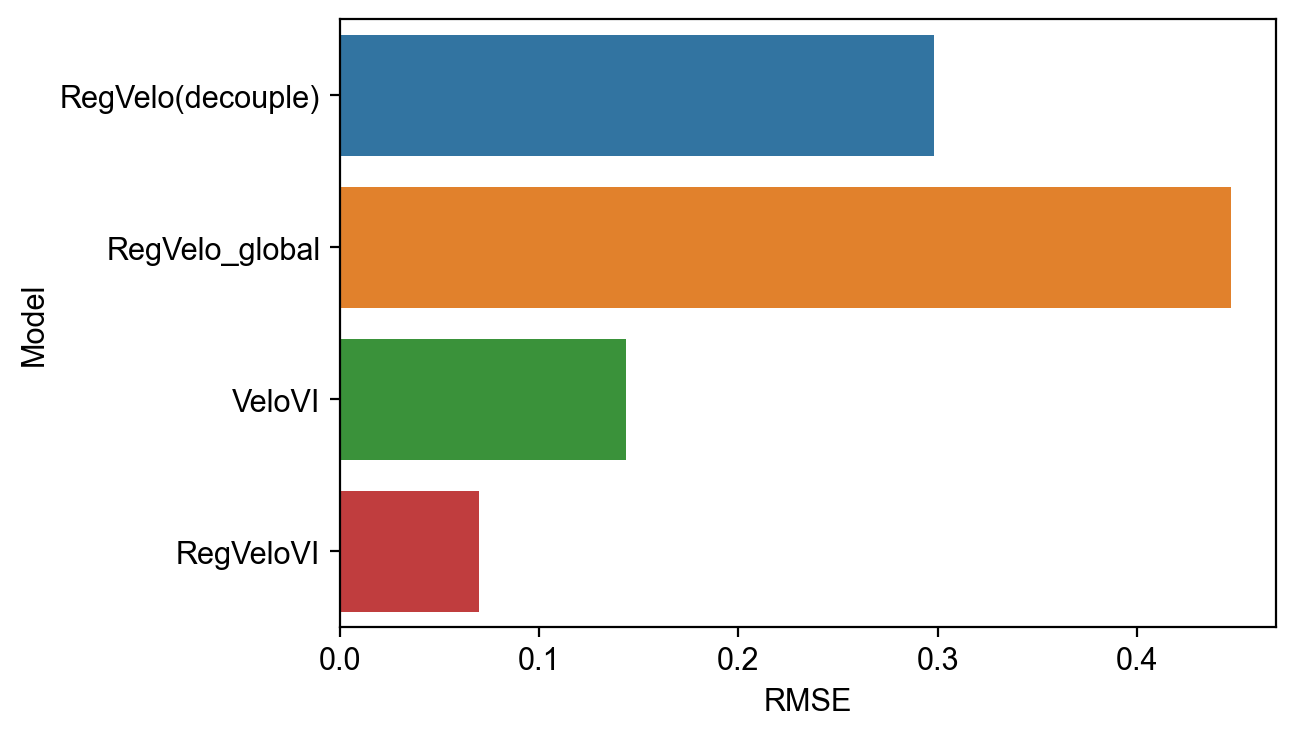

In [217]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="RMSE", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [264]:
test_rmse_regvelo_decouple = pd.DataFrame(test_rmse_regvelo_decouple).assign(Model="RegVelo(decouple)")
test_rmse_regvelo_global = pd.DataFrame(test_rmse_regvelo_global).assign(Model="RegVelo_global")
test_rmse_velovi = pd.DataFrame(test_rmse_velovi).assign(Model="VeloVI")
test_rmse_regvelovi = pd.DataFrame(test_rmse_regvelovi).assign(Model="RegVeloVI")

cdf = pd.concat([test_rmse_regvelo_decouple,test_rmse_regvelo_global,test_rmse_velovi,test_rmse_regvelovi]) 

In [265]:
mdf = pd.melt(cdf, id_vars=['Model'], var_name=['Number'])

In [266]:
mdf.rename(columns = {'value':'rmse'}, inplace = True)

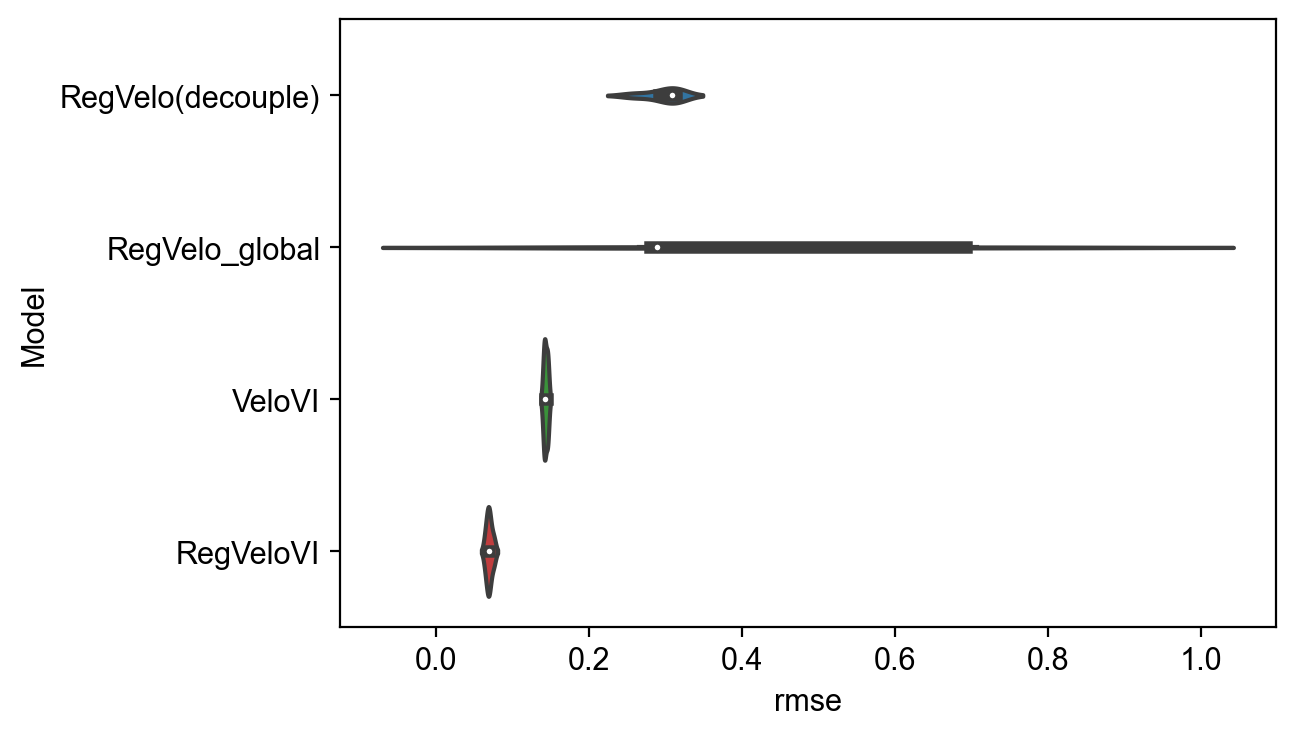

In [268]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.violinplot(y="Model", x="rmse", data=mdf)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [270]:
mdf.to_csv("rmse_methods.csv")

In [1]:
from regvelovi import REGVELOVI

Global seed set to 0
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

In [3]:
scv.set_figure_params()

In [4]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [5]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [6]:
adata.uns["skeleton"].shape

(280, 280)

In [7]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
adata.layers["Ms"].max()

39747.324

In [10]:
adata.X = np.log1p(adata.X.copy())

In [11]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133


In [267]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [268]:
W = torch.ones(W.shape)

In [269]:
W

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [173]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae_0 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0)
reg_vae_0_0001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.0001)
reg_vae_0_001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.001)
reg_vae_0_01 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.01)
reg_vae_0_1 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.1)

In [167]:
reg_vae.module.RBF_interpolate

True

In [168]:
coef = np.array(reg_vae.module.v_encoder.grn.data).ravel()
coef = coef[coef!=0]
coef = np.abs(coef)
coef = pd.DataFrame({"coef":coef})

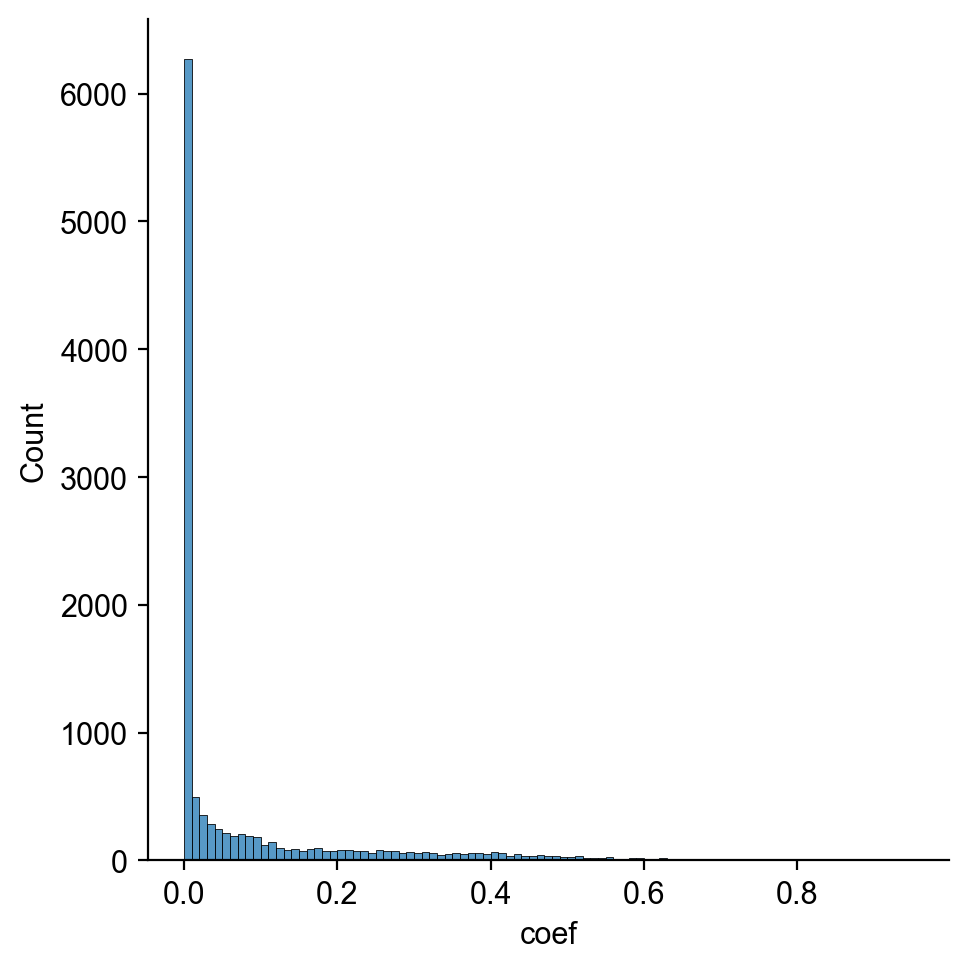

In [169]:
import seaborn as sns
sns.displot(coef, x="coef", binwidth=0.01)

In [139]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [174]:
reg_vae_0.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_0001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_01.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae_0_1.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [175]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [176]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([ 0.3319,  0.3022,  0.4831, -0.0287,  0.3441,  0.2803,  0.3116,  0.4592,
         0.6171,  0.8150,  0.8910,  0.6375,  0.8970,  0.6178,  0.9746,  1.1121,
         0.7802,  0.9664,  0.5805,  1.0388,  0.6448,  0.9083,  1.0867,  0.5530,
         0.9961,  0.6777,  0.9742,  0.7914,  1.0277,  0.9779,  0.5783,  0.4827,
         0.1347,  0.3294,  0.3218,  0.5410,  0.5851,  0.4669,  0.3932,  0.3966,
         0.4539,  0.3946,  0.4707,  0.4323,  0.3817,  0.3813,  0.4635,  0.3200,
         0.4409,  0.2711,  0.5072,  0.4604,  0.6922,  0.9387,  0.5103,  0.5899,
         0.5888,  0.8966,  0.5158,  0.5642,  0.5881,  0.6397,  0.6797,  0.2915,
         0.3712,  0.3848,  0.8247,  0.7216,  0.6880,  0.7154,  1.0002,  0.7245,
         0.7232,  0.8152,  0.7109,  0.4839,  0.8618,  0.7343,  0.6627,  0.6723,
         0.2304,  0.1366,  0.4493,  0.3007,  0.4725,  0.3076,  0.5333,  0.3527,
         0.8736,  0.4130,  0.9955,  0.5813,  0.6624,  0.8889,  0.9026,  0.8252,
         0.6680,  

In [177]:
reg_vae_0.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_0001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_01.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
reg_vae_0_1.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 607/1000:  61%|████████████████████████████▌                  | 607/1000 [09:00<05:49,  1.12it/s, loss=-562, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.312. Signaling Trainer to stop.
Epoch 486/1000:  49%|██████████████████████▊                        | 486/1000 [06:20<06:42,  1.28it/s, loss=-595, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.406. Signaling Trainer to stop.
Epoch 313/1000:  31%|██████████████▋                                | 313/1000 [04:08<09:05,  1.26it/s, loss=-565, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.290. Signaling Trainer to stop.
Epoch 188/1000:  19%|████████▊                                      | 188/1000 [02:29<10:45,  1.26it/s, loss=-528, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.394. Signaling Trainer to stop.
Epoch 252/1000:  25%|███████████▊                                   | 252/1000 [03:15<09:40,  1.29it/s, loss=-564, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.350. Signaling Trainer to stop.


In [270]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 1e-5)
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 546/1000:  55%|█████████████████████████▋                     | 546/1000 [07:44<06:26,  1.17it/s, loss=-591, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 0.341. Signaling Trainer to stop.


In [144]:
#reg_vae.module.v_encoder.grn.prior_net.ravel()

In [271]:
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[-6.4189e-01, -6.7247e-01, -5.9219e-01,  ..., -1.5616e-02,
         -1.5688e-02, -1.5579e-02],
        [-7.5285e-01, -7.9186e-01, -6.9232e-01,  ...,  4.6433e-05,
          5.0583e-05,  5.2205e-05],
        [-8.5781e-02, -6.2951e-02, -7.1766e-02,  ..., -1.0870e-02,
         -9.8954e-03, -1.0380e-02],
        ...,
        [-7.7772e-01, -7.4610e-01, -7.8294e-01,  ...,  2.2492e-05,
          2.2595e-05,  2.6202e-05],
        [-3.2871e-03, -1.9881e-03, -7.1290e-03,  ..., -9.3678e-03,
         -3.3554e-03, -8.3522e-03],
        [-1.1933e-05, -8.6665e-06, -8.7827e-06,  ..., -7.5155e-06,
         -1.1600e-05, -1.0783e-05]], requires_grad=True)

In [146]:
import torch.nn.functional as F
z = reg_vae.module.v_encoder.grn.quantile_concrete(reg_vae.module.v_encoder.grn.get_eps(reg_vae.module.v_encoder.grn.floatTensor(reg_vae.module.v_encoder.grn.par_dim)))
mask = F.hardtanh(z, min_val=0, max_val=1)

AttributeError: 'Parameter' object has no attribute 'quantile_concrete'

In [147]:
reg_vae.module.v_encoder.grn.weights

AttributeError: 'Parameter' object has no attribute 'weights'

In [148]:
corr_m

tensor([[-0.7480, -0.7785, -0.6988,  ...,  0.0215,  0.0174,  0.0176],
        [-0.7603, -0.7980, -0.7035,  ...,  0.0256,  0.0248,  0.0222],
        [ 0.7320,  0.7771,  0.6723,  ..., -0.0875, -0.0794, -0.0794],
        ...,
        [-0.8507, -0.8199, -0.8559,  ...,  0.0234,  0.0215,  0.0182],
        [ 0.1686,  0.1914,  0.1770,  ..., -0.3571, -0.3257, -0.3338],
        [ 0.0454,  0.0865,  0.0711,  ...,  0.0346,  0.0263,  0.0255]])

In [272]:
reg_vae.history.keys()

dict_keys(['validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'kl_weight', 'train_loss_step'])

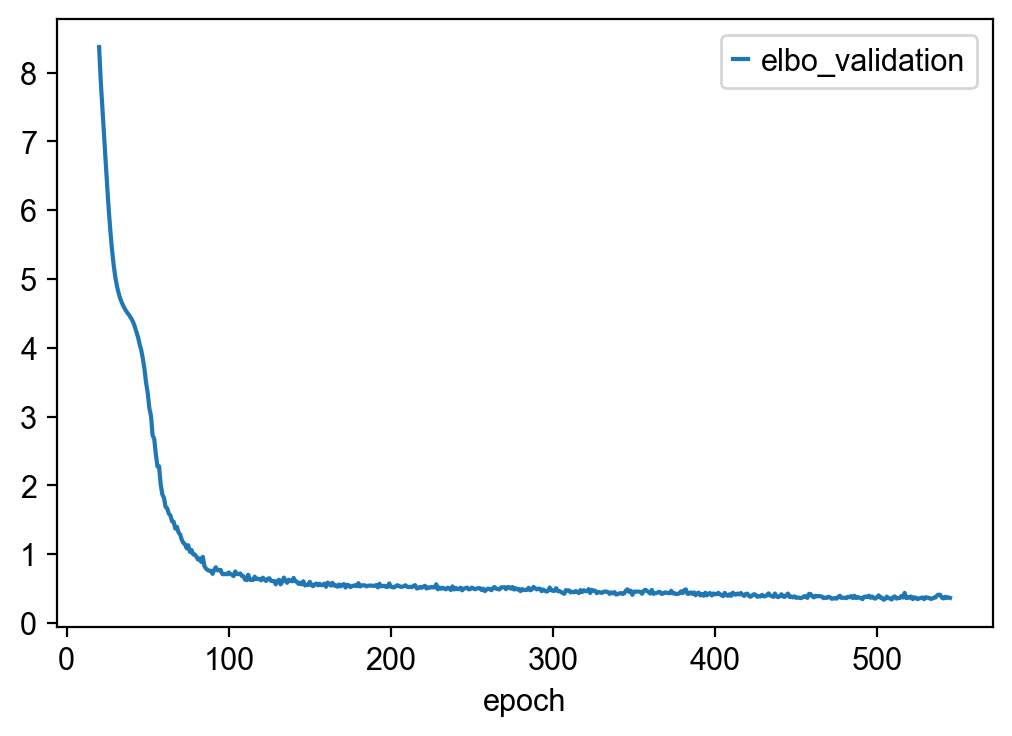

In [273]:
fig, ax = plt.subplots()
reg_vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="train_loss_epoch")
plt.legend()

In [274]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(1144.8832, grad_fn=<AddBackward0>)

In [275]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [276]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


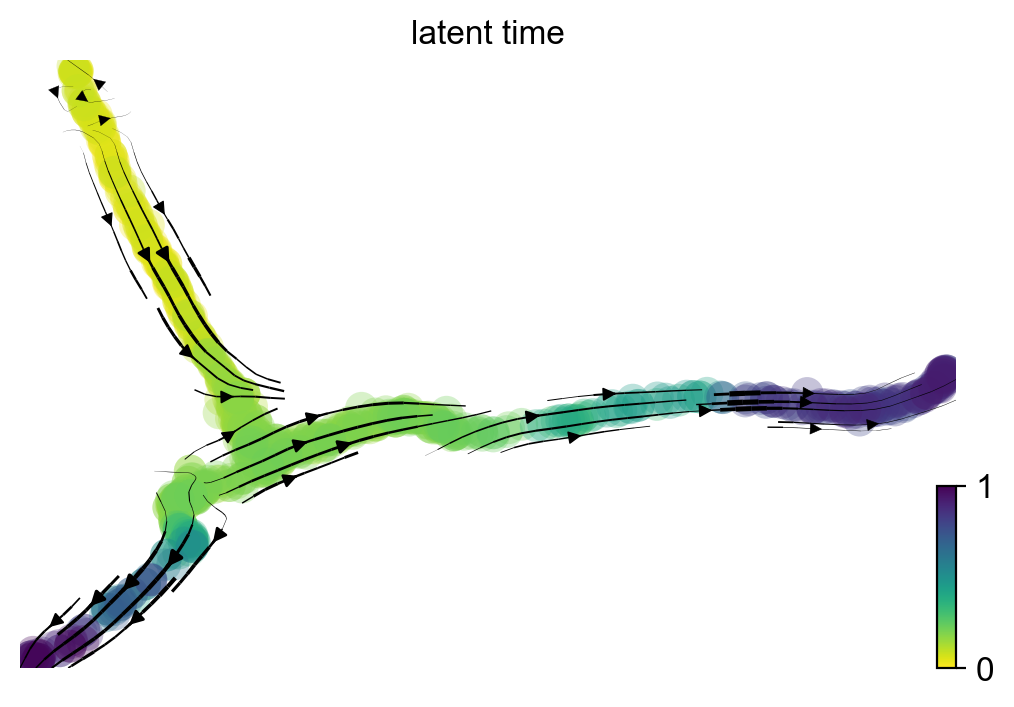

In [277]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [278]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.8494949436395977, pvalue=2.140193906240359e-279)

In [279]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [280]:
adata_target.layers["rna_velocity"].max()

9.66399654745004

In [281]:
corr.mean()

0.19697623370937423

In [282]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [283]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()
GRN = W.T * reg_vae.module.v_encoder.grn
GRN_0 = W.T * reg_vae_0.module.v_encoder.grn
GRN_0_0001 = W.T * reg_vae_0_0001.module.v_encoder.grn
GRN_0_001 = W.T * reg_vae_0_001.module.v_encoder.grn
GRN_0_01 = W.T * reg_vae_0_01.module.v_encoder.grn
GRN_0_1 = W.T * reg_vae_0_1.module.v_encoder.grn

In [284]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [285]:
pre = GRN[W.T==1]
pre_0 = GRN_0[W.T==1]
pre_0_0001 = GRN_0_0001[W.T==1]
pre_0_001 = GRN_0_001[W.T==1]
pre_0_01 = GRN_0_01[W.T==1]
pre_0_1 = GRN_0_1[W.T==1]

In [286]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [287]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [288]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

-0.043178472551953416

In [289]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre_0.detach().numpy()),np.abs(gt))
corr

0.15021386307462492

In [184]:
corr, _ = stats.spearmanr(np.abs(pre_0_0001.detach().numpy()),np.abs(gt))
corr

0.1775403929124936

In [1]:
corr, _ = stats.spearmanr(np.abs(pre_0_001.detach().numpy()),np.abs(gt))
corr

NameError: name 'stats' is not defined

In [186]:
corr, _ = stats.spearmanr(np.abs(pre_0_01.detach().numpy()),np.abs(gt))
corr

0.2879154921496567

In [187]:
corr, _ = stats.spearmanr(np.abs(pre_0_1.detach().numpy()),np.abs(gt))
corr

0.03364324024587542

In [255]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(corr_m.ravel()))
auprc

0.08415091596622591

In [256]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.07231341041383736

In [194]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_0001.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.08517924434333525

In [195]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_001.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.06072865834014396

In [196]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_01.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.05558856105846125

In [197]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_1.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.03887498559935824

In [261]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.7470951631909188

In [199]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_0001.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.710035689858971

In [200]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_001.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.6331234944199116

In [201]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_01.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.6193964495091042

In [202]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_1.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.5259067357512953

In [207]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(corr_m.ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.7924633098544481

In [257]:
d = {'AUPRC': [0.08415091596622591,
              0.07231341041383736,
              0.0811259842346571, 
              0.08517924434333525,
              0.06072865834014396,
              0.05558856105846125,
              0.03887498559935824,
              0.08291278911721325],
     'Model': ["Pearsonr","RegVelo(lambda = 0)","RegVelo(lambda = 1e-5)","RegVelo(lambda = 1e-4)","RegVelo(lambda = 1e-3)","RegVelo(lambda = 1e-2)","RegVelo(lambda = 1e-1)","GRNBoost2(SCENIC)"]}
df = pd.DataFrame(data=d)

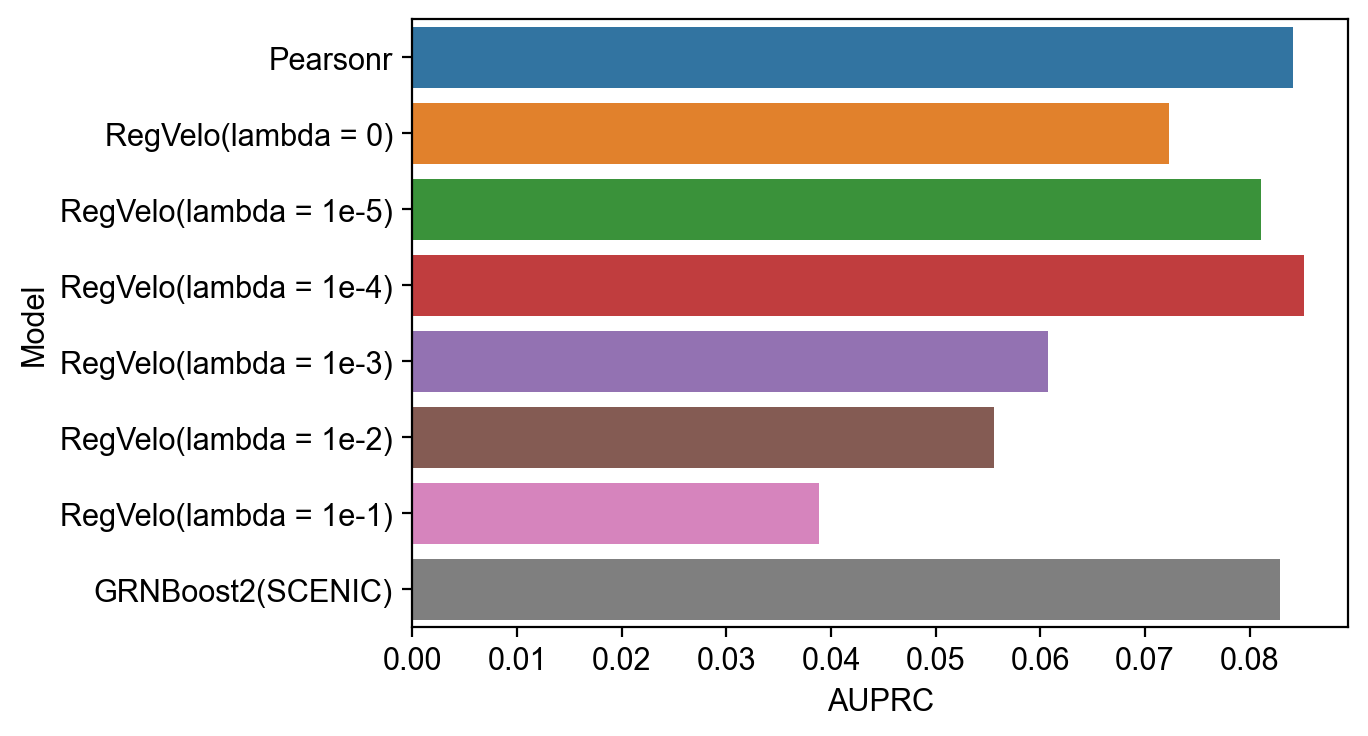

In [259]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="AUPRC", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [262]:
d = {'AUROC': [0.7924633098544481,
              0.6641598462534346,
              0.7470951631909188, 
              0.710035689858971,
              0.6331234944199116,
              0.6193964495091042,
              0.5259067357512953,
              0.7330168734841195],
     'Model': ["Pearsonr","RegVelo(lambda = 0)","RegVelo(lambda = 1e-5)","RegVelo(lambda = 1e-4)","RegVelo(lambda = 1e-3)","RegVelo(lambda = 1e-2)","RegVelo(lambda = 1e-1)","GRNBoost2(SCENIC)"]}
df = pd.DataFrame(data=d)

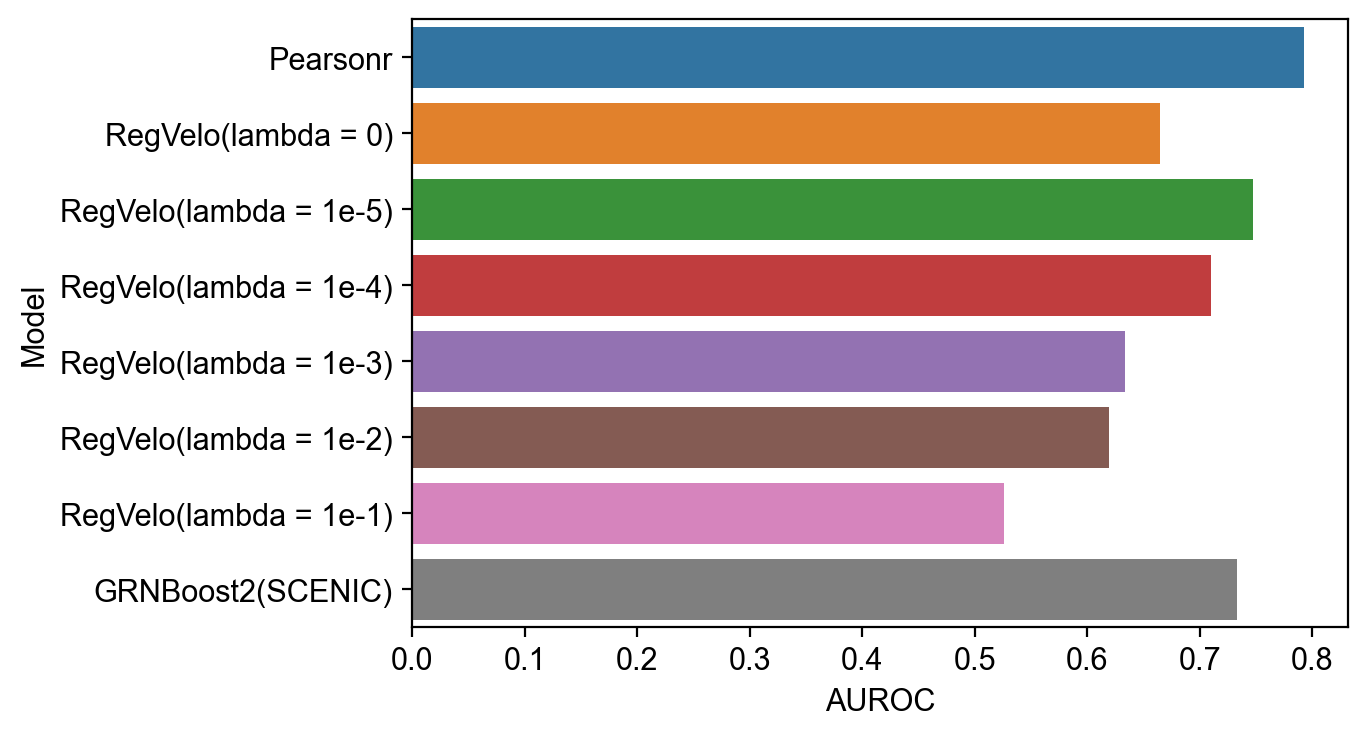

In [263]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="AUROC", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [291]:
d = {'Corr': [0.08415091596622591,
              0.15021386307462492,
              -0.043178472551953416,
              0.1775403929124936, 
              0.41002474262746413,
              0.2879154921496567,
              0.03364324024587542,
              0.36242387183720415],
     'Model': ["Pearsonr","RegVelo(lambda = 0)","RegVelo(lambda = 1e-5)","RegVelo(lambda = 1e-4)","RegVelo(lambda = 1e-3)","RegVelo(lambda = 1e-2)","RegVelo(lambda = 1e-1)","GRNBoost2(SCENIC)"]}
df = pd.DataFrame(data=d)

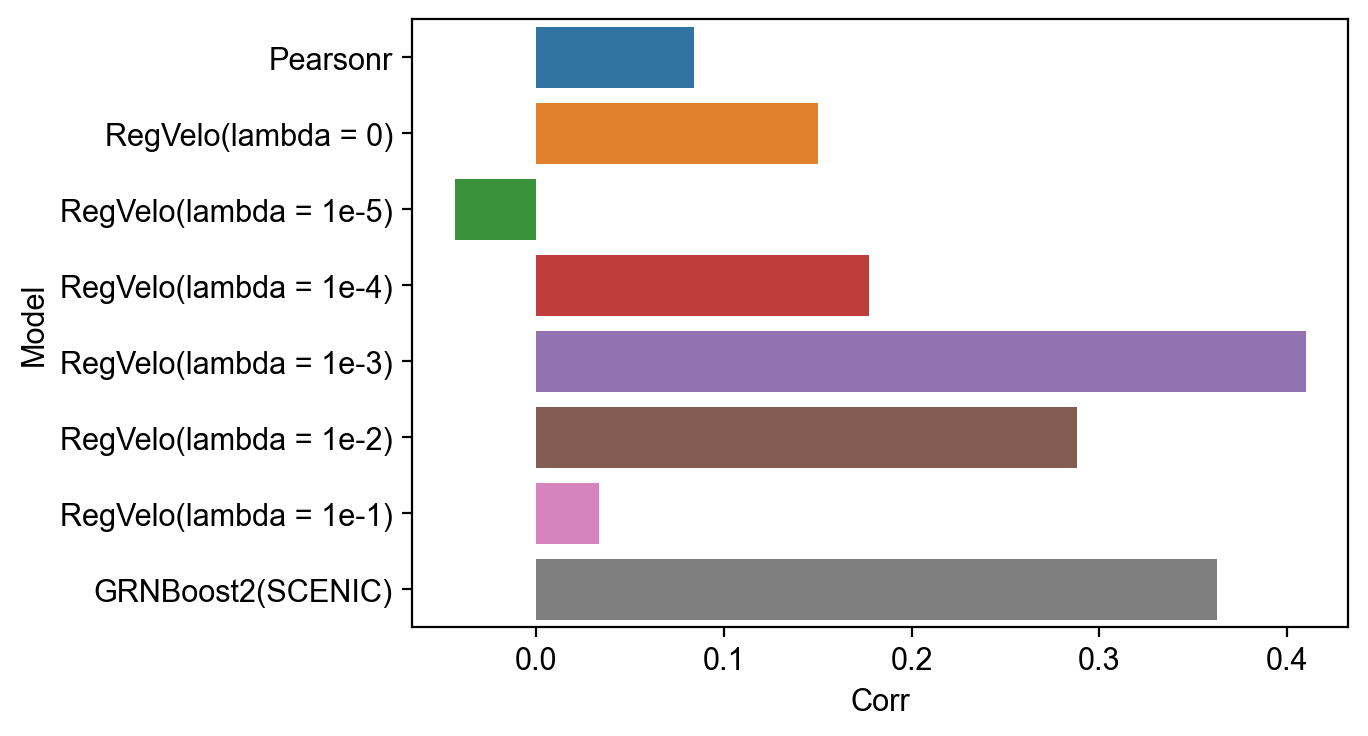

In [293]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Corr", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [177]:
#TODO: split as two stage training, 1) Interpolation stage 2) froze encoder and decoder update GRN paramters and Kinetic parameters.
from regvelovi import REGVELOVI

In [178]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

In [179]:
scv.set_figure_params()

In [180]:
adata = sc.read_h5ad("dataset_branch_v2.h5ad")

In [181]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [182]:
adata.uns["skeleton"].shape

(280, 280)

In [183]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [184]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [185]:
adata.layers["Ms"].max()

39747.324

In [186]:
adata.X = np.log1p(adata.X.copy())

In [187]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 88
num targets: 133


In [188]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [189]:
#W = torch.ones(W.shape)

In [190]:
W.sum()/(88*133)

tensor(0.0330)

In [191]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0)
#reg_vae_0_0001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.0001)
#reg_vae_0_001 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.001)
#reg_vae_0_01 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.01)
#reg_vae_0_1 = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 0.1)

In [192]:
reg_vae.module.RBF_interpolate

True

In [193]:
coef = np.array(reg_vae.module.v_encoder.grn.data).ravel()
coef = coef[coef!=0]
coef = np.abs(coef)
coef = pd.DataFrame({"coef":coef})

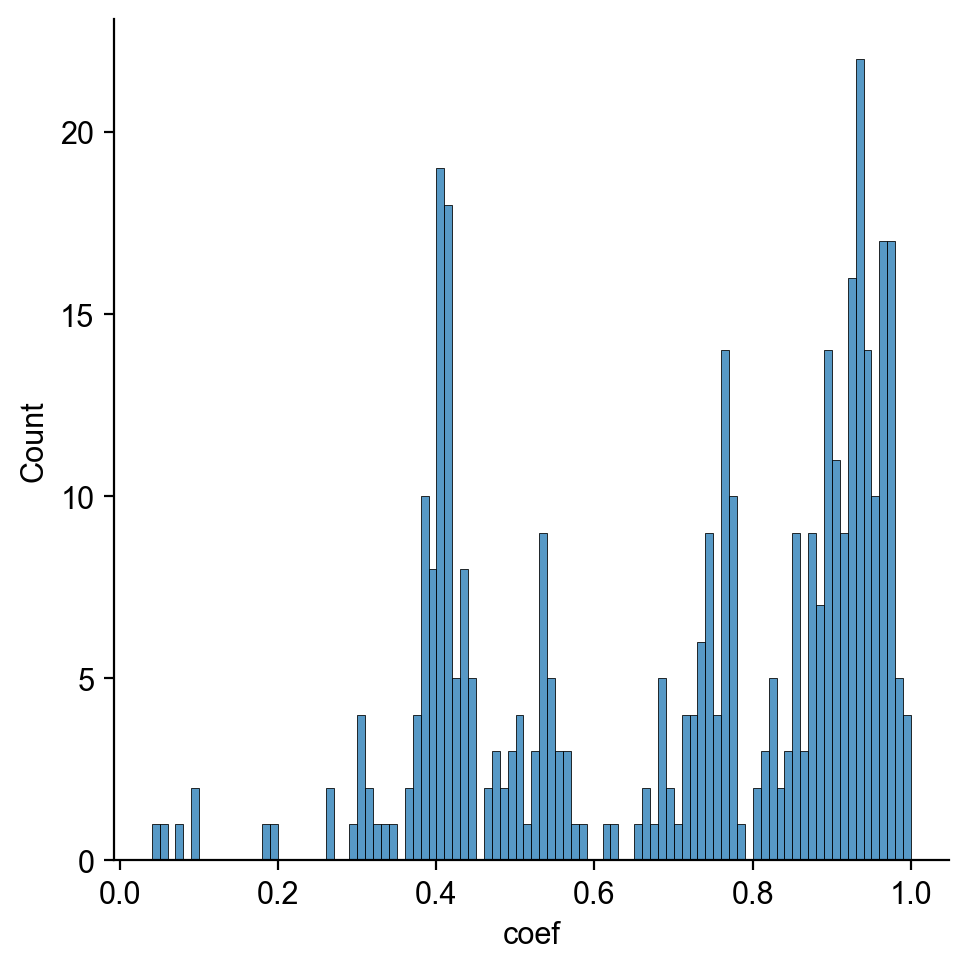

In [194]:
import seaborn as sns
sns.displot(coef, x="coef", binwidth=0.01)

In [195]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [196]:
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_0001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_001.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_01.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
#reg_vae_0_1.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [197]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [198]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.2837, 0.3349, 0.4678, 0.0175, 0.4040, 0.3680, 0.4183, 0.3693, 0.3043,
        0.4052, 0.4751, 0.4462, 0.4470, 0.4189, 0.4169, 0.5017, 0.4129, 0.4602,
        0.4169, 0.4801, 0.4721, 0.4369, 0.4919, 0.3943, 0.4950, 0.4681, 0.4105,
        0.4673, 0.4862, 0.4699, 0.4875, 0.4375, 0.2296, 0.4422, 0.3303, 0.5031,
        0.3417, 0.4225, 0.3829, 0.3684, 0.4063, 0.3868, 0.4212, 0.4071, 0.4460,
        0.4173, 0.4596, 0.3101, 0.4275, 0.3168, 0.4852, 0.4858, 0.3787, 0.5065,
        0.4598, 0.4485, 0.4762, 0.5033, 0.3864, 0.4375, 0.2525, 0.3609, 0.4121,
        0.2830, 0.2591, 0.4056, 0.4220, 0.4145, 0.4183, 0.4791, 0.4869, 0.4208,
        0.3835, 0.3845, 0.4808, 0.2246, 0.4352, 0.4272, 0.4049, 0.2792, 0.2199,
        0.2697, 0.4384, 0.2978, 0.4583, 0.3149, 0.4215, 0.2221, 0.3554, 0.1695,
        0.4504, 0.3040, 0.4098, 0.4145, 0.4269, 0.3463, 0.4876, 0.4190, 0.2121,
        0.2435, 0.1957, 0.2750, 0.3196, 0.2718, 0.4824, 0.3453, 0.4284, 0.2497,
        0.4257, 0.

In [199]:
reg_vae.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_0001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_001.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_01.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)
#reg_vae_0_1.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 158/1000:  16%|███████▍                                       | 158/1000 [01:58<10:29,  1.34it/s, loss=-469, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.486. Signaling Trainer to stop.


In [126]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T,RBF_interpolate=True,lam = 1e-5)
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])
reg_vae.train(max_epochs=1000,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 177/1000:  18%|████████▎                                      | 177/1000 [02:22<11:04,  1.24it/s, loss=-491, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 3.888. Signaling Trainer to stop.


In [144]:
#reg_vae.module.v_encoder.grn.prior_net.ravel()

In [153]:
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[-0.1206, -0.0000, -0.0731,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.1329,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [154]:
corr_m

tensor([[-0.7480, -0.7785, -0.6988,  ...,  0.0215,  0.0174,  0.0176],
        [-0.7603, -0.7980, -0.7035,  ...,  0.0256,  0.0248,  0.0222],
        [ 0.7320,  0.7771,  0.6723,  ..., -0.0875, -0.0794, -0.0794],
        ...,
        [-0.8507, -0.8199, -0.8559,  ...,  0.0234,  0.0215,  0.0182],
        [ 0.1686,  0.1914,  0.1770,  ..., -0.3571, -0.3257, -0.3338],
        [ 0.0454,  0.0865,  0.0711,  ...,  0.0346,  0.0263,  0.0255]])

In [155]:
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[-0.1206, -0.0000, -0.0731,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.1329,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [156]:
reg_vae.history.keys()

dict_keys(['validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'kl_weight', 'train_loss_step'])

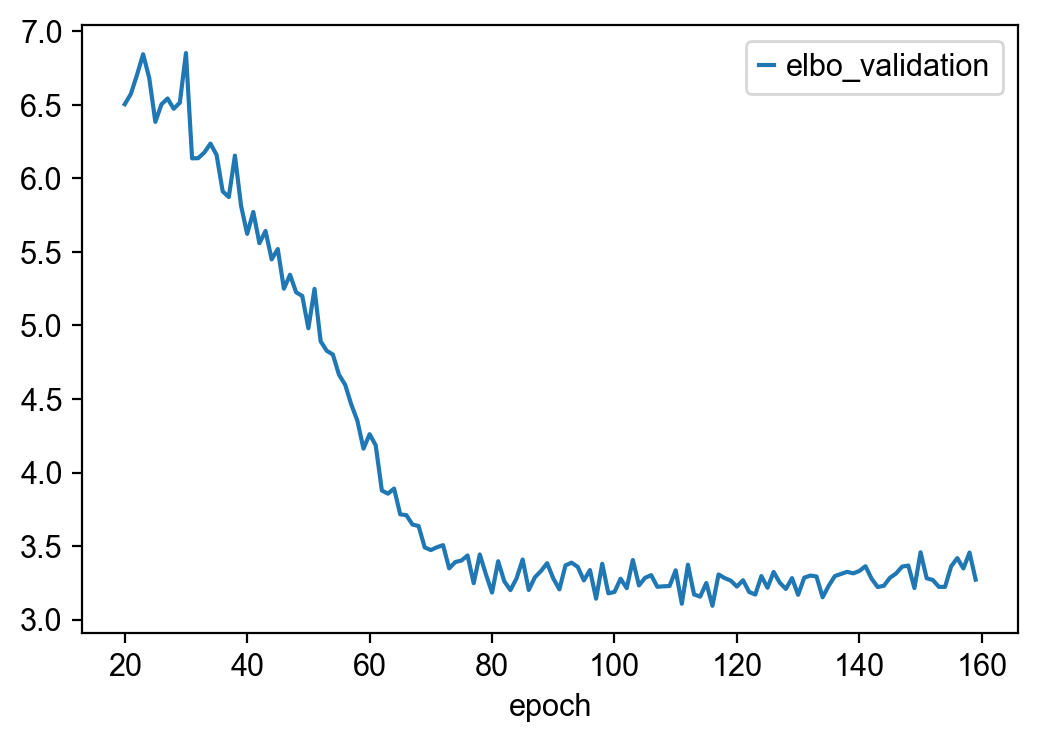

In [157]:
fig, ax = plt.subplots()
reg_vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="train_loss_epoch")
plt.legend()

In [158]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(81.9446, grad_fn=<AddBackward0>)

In [159]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [160]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


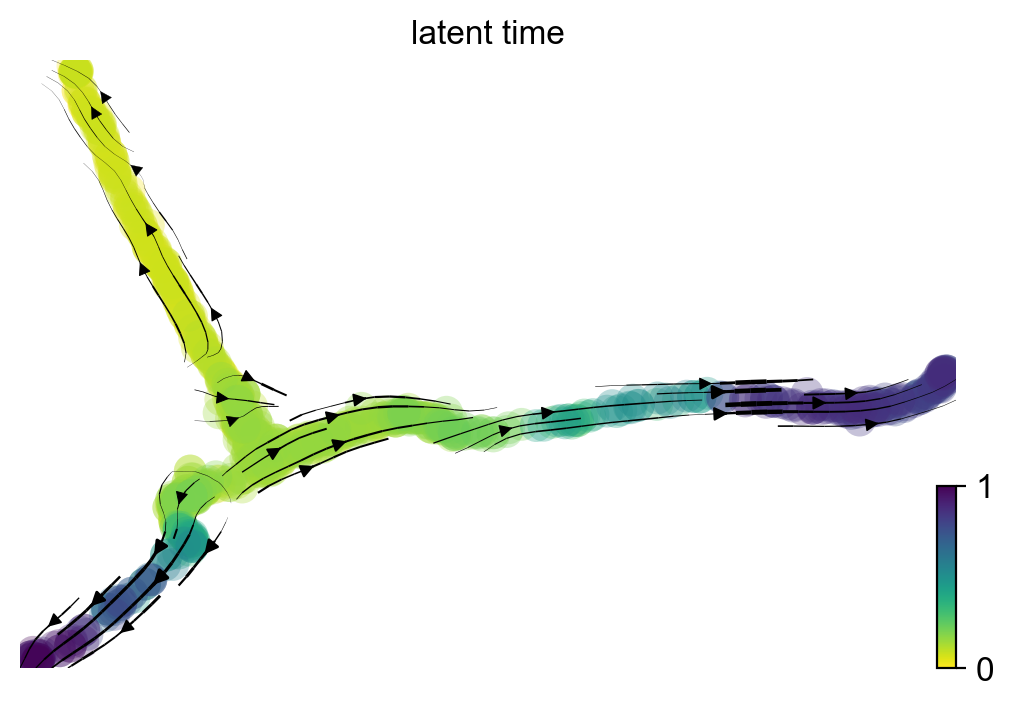

In [161]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [162]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.8301731037639699, pvalue=1.7366953390922748e-255)

In [163]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:133,133:(133*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [164]:
adata_target.layers["rna_velocity"].max()

9.66399654745004

In [165]:
corr.mean()

0.19062707091306663

In [166]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [167]:
W

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [168]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()
GRN = W.T * reg_vae.module.v_encoder.grn
#GRN_0 = W.T * reg_vae_0.module.v_encoder.grn
#GRN_0_0001 = W.T * reg_vae_0_0001.module.v_encoder.grn
#GRN_0_001 = W.T * reg_vae_0_001.module.v_encoder.grn
#GRN_0_01 = W.T * reg_vae_0_01.module.v_encoder.grn
#GRN_0_1 = W.T * reg_vae_0_1.module.v_encoder.grn

In [169]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [170]:
pre = GRN[W.T==1]
#pre_0 = GRN_0[W.T==1]
#pre_0_0001 = GRN_0_0001[W.T==1]
#pre_0_001 = GRN_0_001[W.T==1]
#pre_0_01 = GRN_0_01[W.T==1]
#pre_0_1 = GRN_0_1[W.T==1]

In [171]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [172]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [173]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.004354800699920725

In [176]:
pre

tensor([-0.1206, -0.0731, -0.1329, -0.1236, -0.1165,  0.0604,  0.0774, -0.1894,
        -0.1794, -0.1881, -0.1762, -0.2147, -0.2050,  0.2813,  0.3958,  0.3092,
         0.2539,  0.2692,  0.3173,  0.3431,  0.3796,  0.1048,  0.2932,  0.3328,
         0.3265,  0.6510,  0.6666,  0.8021,  0.8046,  0.2788,  0.2426,  0.3026,
         0.4641,  0.6029,  0.6560,  0.7463,  0.7494,  0.2276,  0.2758,  0.2699,
         0.3954,  0.8502,  0.8324,  0.8323,  0.1670,  0.7141,  0.7227,  0.7458,
         0.6954,  0.1629,  0.1830,  0.3926,  0.3764,  0.1436,  0.2499,  0.1542,
         0.2705,  0.2954,  0.3853,  0.1541,  0.1718,  0.4502,  0.3401,  0.3005,
         0.1593,  0.2125,  0.4060,  0.2910,  0.3652,  0.4933,  0.2720,  0.1398,
         0.1719,  0.5402,  0.5088,  0.2881,  0.3553,  0.4025,  0.2151,  0.1818,
         0.2972,  0.1224,  0.2919,  0.2101,  0.3239,  0.1192,  0.2753,  0.2082,
         0.2929,  0.1334,  0.3420,  0.1700,  0.2873,  0.3785,  0.2913,  0.1444,
         0.1855,  0.4495,  0.4397,  0.15

In [83]:
gt

array([ -10.        ,  -10.        ,  -10.        ,  -10.        ,
        -10.        ,  -10.        ,  -10.        ,  -10.        ,
        -10.        ,  -10.        ,  -10.        ,  -10.        ,
        -10.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.     

In [84]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre_0.detach().numpy()),np.abs(gt))
corr

NameError: name 'pre_0' is not defined

In [85]:
corr, _ = stats.spearmanr(np.abs(pre_0_0001.detach().numpy()),np.abs(gt))
corr

NameError: name 'pre_0_0001' is not defined

In [86]:
corr, _ = stats.spearmanr(np.abs(pre_0_001.detach().numpy()),np.abs(gt))
corr

NameError: name 'pre_0_001' is not defined

In [186]:
corr, _ = stats.spearmanr(np.abs(pre_0_01.detach().numpy()),np.abs(gt))
corr

0.2879154921496567

In [187]:
corr, _ = stats.spearmanr(np.abs(pre_0_1.detach().numpy()),np.abs(gt))
corr

0.03364324024587542

In [255]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(corr_m.ravel()))
auprc

0.08415091596622591

In [44]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.09862378691851087

In [194]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_0001.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.08517924434333525

In [195]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_001.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.06072865834014396

In [196]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_01.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.05558856105846125

In [197]:
import sklearn
auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(reg_vae_0_1.module.v_encoder.grn.detach().numpy().ravel()))
auprc

0.03887498559935824

In [112]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.6369055848494809

In [77]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_0001.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

NameError: name 'reg_vae_0_0001' is not defined

In [200]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_001.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.6331234944199116

In [201]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_01.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.6193964495091042

In [202]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(reg_vae_0_1.module.v_encoder.grn.detach().numpy().ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.5259067357512953

In [207]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = abs(corr_m.ravel()), pos_label = 1) #positive class is 1; negative class is 0
auroc = sklearn.metrics.auc(fpr, tpr)
auroc

0.7924633098544481

In [257]:
d = {'AUPRC': [0.08415091596622591,
              0.07231341041383736,
              0.0811259842346571, 
              0.08517924434333525,
              0.06072865834014396,
              0.05558856105846125,
              0.03887498559935824,
              0.08291278911721325],
     'Model': ["Pearsonr","RegVelo(lambda = 0)","RegVelo(lambda = 1e-5)","RegVelo(lambda = 1e-4)","RegVelo(lambda = 1e-3)","RegVelo(lambda = 1e-2)","RegVelo(lambda = 1e-1)","GRNBoost2(SCENIC)"]}
df = pd.DataFrame(data=d)

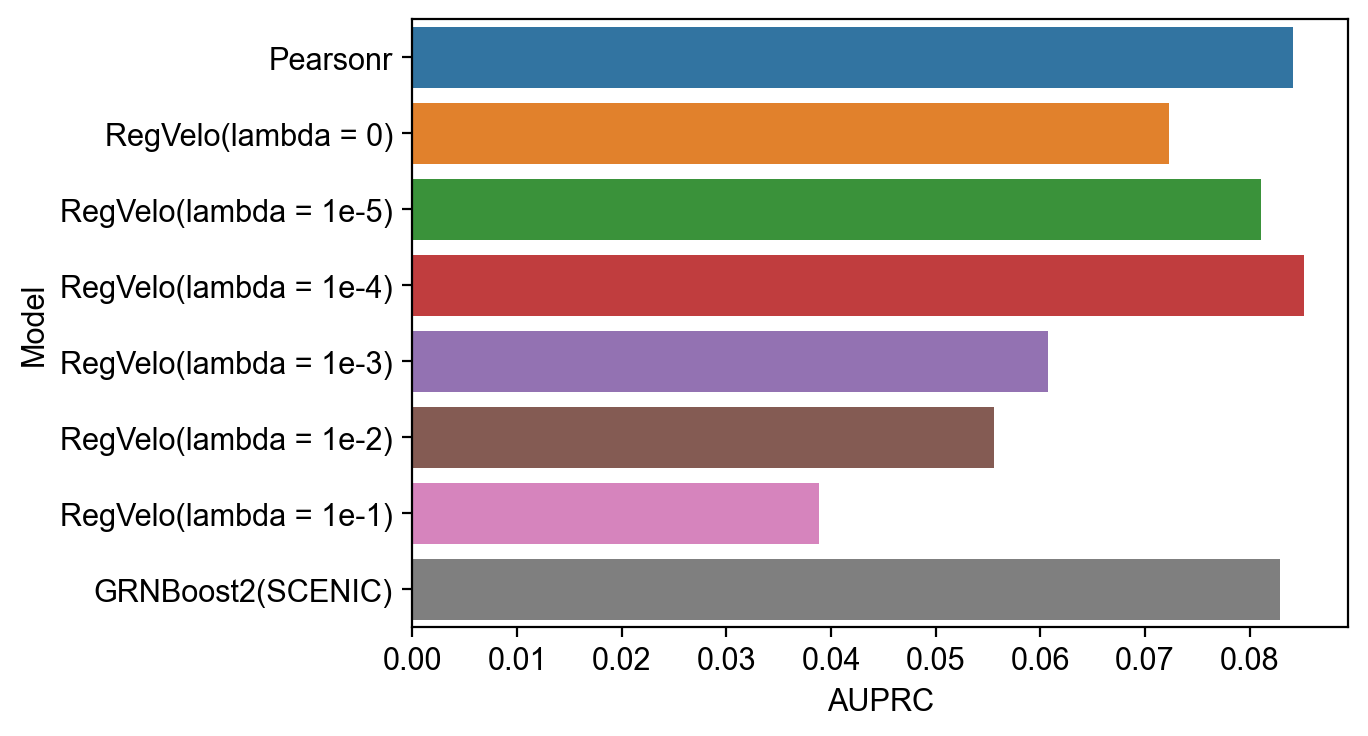

In [259]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="AUPRC", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [262]:
d = {'AUROC': [0.7924633098544481,
              0.6641598462534346,
              0.7470951631909188, 
              0.710035689858971,
              0.6331234944199116,
              0.6193964495091042,
              0.5259067357512953,
              0.7330168734841195],
     'Model': ["Pearsonr","RegVelo(lambda = 0)","RegVelo(lambda = 1e-5)","RegVelo(lambda = 1e-4)","RegVelo(lambda = 1e-3)","RegVelo(lambda = 1e-2)","RegVelo(lambda = 1e-1)","GRNBoost2(SCENIC)"]}
df = pd.DataFrame(data=d)

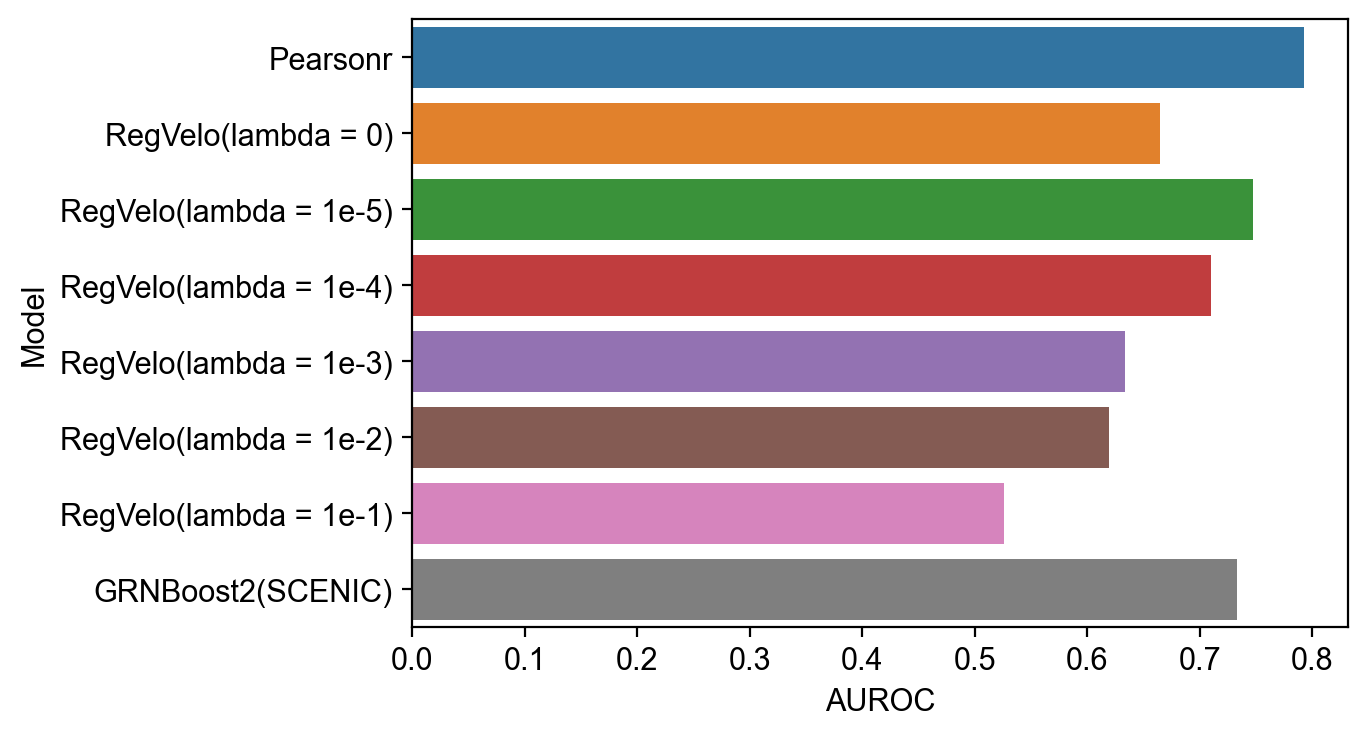

In [263]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="AUROC", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [291]:
d = {'Corr': [0.08415091596622591,
              0.15021386307462492,
              -0.043178472551953416,
              0.1775403929124936, 
              0.41002474262746413,
              0.2879154921496567,
              0.03364324024587542,
              0.36242387183720415],
     'Model': ["Pearsonr","RegVelo(lambda = 0)","RegVelo(lambda = 1e-5)","RegVelo(lambda = 1e-4)","RegVelo(lambda = 1e-3)","RegVelo(lambda = 1e-2)","RegVelo(lambda = 1e-1)","GRNBoost2(SCENIC)"]}
df = pd.DataFrame(data=d)

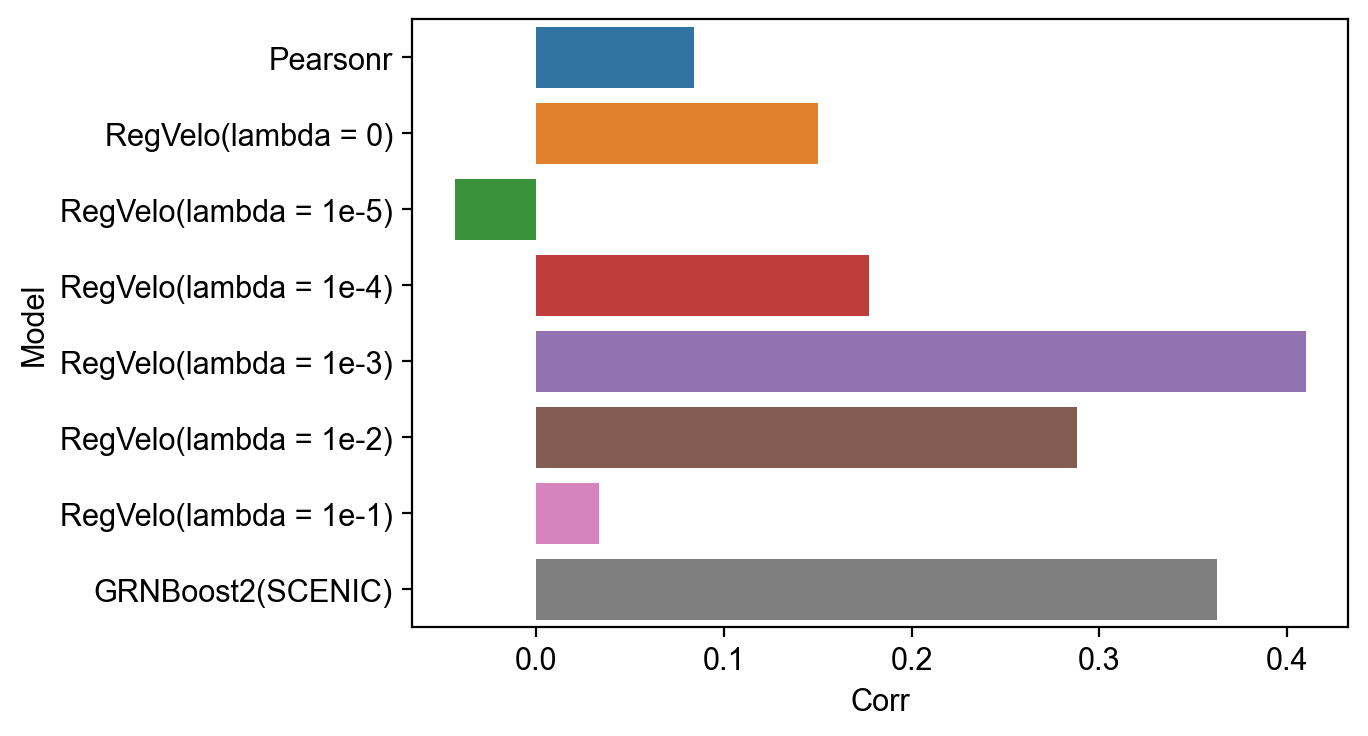

In [293]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Corr", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [153]:
import pandas as pd
import scvelo as scv
scv.set_figure_params()
d = {'Spearman_Correlation': [
              0.5790204539187273,
              0.48047928408535406,
              0.3388070605151547,
              0.11705164397411455], 
     'Model': ["RegVelo","SCENIC", "CellOracle","Pearsonr"]}
df = pd.DataFrame(data=d)

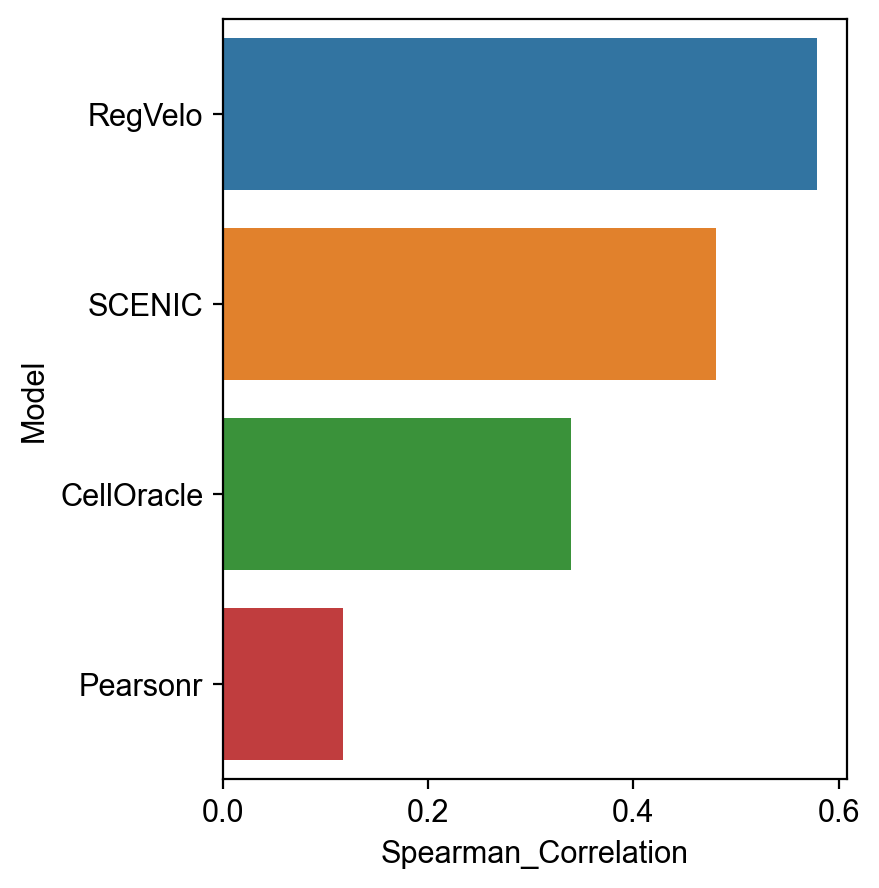

In [154]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 5))
ax = sns.barplot(y="Model", x="Spearman_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [62]:
import math
import torch
import math
import torch.nn.functional as F
from torch.nn.modules import Module
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair as pair
from torch.autograd import Variable
from torch.nn import init

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F


def hard_sigmoid(x):
    return torch.min(torch.max(x, torch.zeros_like(x)), torch.ones_like(x))

class GRN_layer(Module):
    """Implementation of L0 regularization for the input units of a fully connected layer"""
    def __init__(self, n_targets, n_regulators, W_init, prior_net,loc_mean=0, loc_sdev=0.01, beta=2 / 3, gamma=-0.1,
                 zeta=1.1, fix_temp=True, **kwargs):
        """
        :param n_targets: number of targets
        :param n_regulators: number of regulators
        :param W_init: GRN initialization
        :param prior_net: GRN Skeleton
        :param bias: Whether we use a bias
        :param weight_decay: Strength of the L2 penalty
        :param droprate_init: Dropout rate that the L0 gates will be initialized to
        :param temperature: Temperature of the concrete distribution
        :param lamba: Strength of the L0 penalty
        :param local_rep: Whether we will use a separate gate sample per element in the minibatch
        """
        super(GRN_layer, self).__init__()
        self.n_targets = n_targets
        self.n_regulators = n_regulators
        self.weights = Parameter(W_init*prior_net.float())
        self._size = self.weights.size()
        self.loc = nn.Parameter(torch.zeros(self._size).normal_(loc_mean, loc_sdev))
        self.temp = beta if fix_temp else nn.Parameter(torch.zeros(1).fill_(beta))
        self.register_buffer("uniform", torch.zeros(self._size))
        self.gamma = gamma
        self.zeta = zeta
        self.gamma_zeta_ratio = math.log(-gamma / zeta)
        self.floatTensor = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor

    def _get_mask(self):
        if self.training:
            self.uniform.uniform_()
            u = Variable(self.uniform)
            s = F.sigmoid((torch.log(u) - torch.log(1 - u) + self.loc) / self.temp)
            s = s * (self.zeta - self.gamma) + self.gamma
        else:
            s = F.sigmoid(self.loc) * (self.zeta - self.gamma) + self.gamma
        return hard_sigmoid(s)

    def _get_grn(self):
        mask = self._get_mask()
        weights = self.weights * mask

        return mask
        
    def _get_penalty(self):
        if self.training:
            penalty = F.sigmoid(self.loc - self.temp * self.gamma_zeta_ratio).sum()
        else:
            penalty = 0
        
        return penalty

    def forward(self, input):
        mask = self._get_mask()
        weights = self.weights * mask
        output = input * weights
        return output

    def __repr__(self):
        s = ('{name}(Gene Regulatory Network Layer, n_regulators={n_regulators}, n_targets={n_targets}, droprate_init={droprate_init}, '
             'lamba={lamba}, temperature={temperature}, weight_decay={prior_prec}, '
            )
        s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)

In [20]:
W_init = reg_vae.module.v_encoder.grn.weights
prior_net = W.T

In [21]:
n_targets = 133
n_regulators = 88

In [22]:
grn = GRN_layer(n_targets=n_targets, n_regulators=n_regulators, W_init=W_init, prior_net=prior_net)

In [145]:
def _hook_mask_no_regulator(grad):
    return grad

w_grn = grn.weights.register_hook(_hook_mask_no_regulator)

In [139]:
grn.prior_net

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [112]:
weights[weights!=0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [113]:
weights

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [50]:
import torch
import math
import torch.nn.functional as F
from torch.nn.modules import Module
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair as pair
from torch.autograd import Variable
from torch.nn import init

limit_a, limit_b, epsilon = -.1, 1.1, 1e-6


class GRN_layer(Module):
    """Implementation of L0 regularization for the input units of a fully connected layer"""
    def __init__(self, n_targets, n_regulators, W_init, prior_net,lamba = 1.,bias=False, weight_decay=1., droprate_init=0.5, temperature=2./3.,
                  local_rep=False, **kwargs):
        """
        :param n_targets: number of targets
        :param n_regulators: number of regulators
        :param W_init: GRN initialization
        :param prior_net: GRN Skeleton
        :param bias: Whether we use a bias
        :param weight_decay: Strength of the L2 penalty
        :param droprate_init: Dropout rate that the L0 gates will be initialized to
        :param temperature: Temperature of the concrete distribution
        :param lamba: Strength of the L0 penalty
        :param local_rep: Whether we will use a separate gate sample per element in the minibatch
        """
        super(GRN_layer, self).__init__()
        self.n_targets = n_targets
        self.n_regulators = n_regulators
        self.prior_prec = weight_decay
        self.weights = Parameter(W_init)
        self.prior_net = prior_net.float()
        self._size = self.weights.size()
        self.qz_loga = Parameter(torch.Tensor(self._size))
        self.temperature = temperature
        self.droprate_init = droprate_init if droprate_init != 0. else 0.5
        self.lamba = lamba
        self.use_bias = False
        self.bias = None
        self.local_rep = local_rep
        self.floatTensor = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
        self.reset_parameters()
        print(self)

    def reset_parameters(self):
        self.weights.data = self.weights.data * self.prior_net
        self.qz_loga.data.normal_(math.log(1 - self.droprate_init) - math.log(self.droprate_init), 1e-2)

    def constrain_parameters(self, **kwargs):
        self.qz_loga.data.clamp_(min=math.log(1e-2), max=math.log(1e2))

    def cdf_qz(self, x):
        """Implements the CDF of the 'stretched' concrete distribution"""
        xn = (x - limit_a) / (limit_b - limit_a)
        logits = math.log(xn) - math.log(1 - xn)
        return F.sigmoid(logits * self.temperature - self.qz_loga).clamp(min=epsilon, max=1 - epsilon)

    def quantile_concrete(self, x):
        """Implements the quantile, aka inverse CDF, of the 'stretched' concrete distribution"""
        y = F.sigmoid((torch.log(x) - torch.log(1 - x) + self.qz_loga) / self.temperature)
        return y * (limit_b - limit_a) + limit_a

    def _reg_w(self):
        """Expected L0 norm under the stochastic gates, takes into account and re-weights also a potential L2 penalty"""
        q0 = self.cdf_qz(0)
        logpw_col = (.5 * self.prior_prec * self.weights.pow(2)) + self.lamba
        logpw = torch.sum((1 - q0) * logpw_col)
        logpb = 0 
        return logpw + logpb

    
    def _get_penalty(self):
        return self._reg_w()

    def get_eps(self, size):
        """Uniform random numbers for the concrete distribution"""
        eps = self.floatTensor(size).uniform_(epsilon, 1-epsilon)
        eps = Variable(eps)
        return eps

    def sample_weights(self):
        z = self.quantile_concrete(self.get_eps(self.floatTensor(self._size)))
        mask = F.hardtanh(z, min_val=0, max_val=1)
        return mask * self.weights

    def forward(self, input):
        weights = self.sample_weights()
        output = input * weights
        
        return output

    def _get_mask(self):
        return F.sigmoid(self.qz_loga) * (limit_b - limit_a) + limit_a

    def _get_grn(self):
        mask = self._get_mask()
        weights = self.weights * mask

        return weights

    def __repr__(self):
        s = ('{name}(Gene Regulatory Network Layer, n_regulators={n_regulators}, n_targets={n_targets}, droprate_init={droprate_init}, '
             'lamba={lamba}, temperature={temperature}, weight_decay={prior_prec}, '
            )
        s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)

In [57]:
W_init = reg_vae.module.v_encoder.grn.weights
prior_net = W.T

In [63]:
n_targets = 133
n_regulators = 88
grn = GRN_layer(n_targets=n_targets, n_regulators=n_regulators, W_init=W_init, prior_net=prior_net)

In [59]:
grn(torch.randn(W_init.size()))

tensor([[ 1.1828e-01,  4.4922e-01, -4.9416e-01,  ...,  1.6634e-02,
          5.1473e-04,  5.2706e-06],
        [-3.8925e-01,  1.9826e-01,  2.3845e-01,  ..., -3.1946e-04,
         -0.0000e+00, -0.0000e+00],
        [ 0.0000e+00, -5.1227e-01, -4.4395e-01,  ...,  0.0000e+00,
          1.5254e-01,  4.7299e-02],
        ...,
        [-0.0000e+00,  7.9773e-02,  7.0894e-02,  ..., -1.1185e-04,
          7.3264e-03,  3.4665e-03],
        [-9.9274e-03, -4.9358e-02, -5.0917e-02,  ..., -6.0713e-02,
         -3.2531e-02, -2.0733e-01],
        [-4.6284e-02, -3.7514e-02,  7.1097e-03,  ..., -0.0000e+00,
         -1.3962e-02,  2.4088e-02]], grad_fn=<MulBackward0>)

In [64]:
grn._get_grn()

tensor([[0.0767, 0.5673, 0.0000,  ..., 0.0000, 0.7704, 0.2377],
        [0.9805, 1.0000, 1.0000,  ..., 0.0000, 1.0000, 1.0000],
        [0.4903, 1.0000, 0.1472,  ..., 0.0231, 1.0000, 0.7426],
        ...,
        [0.9971, 0.0765, 0.3022,  ..., 1.0000, 0.7753, 0.0277],
        [0.0482, 0.9827, 0.0000,  ..., 0.5029, 0.6183, 1.0000],
        [0.9286, 0.9609, 0.0000,  ..., 1.0000, 0.0000, 0.0000]],
       grad_fn=<MinimumBackward0>)

In [137]:
p

NameError: name 'p' is not defined

In [325]:
penalty = F.sigmoid(grn.loc - grn.temp * grn.gamma_zeta_ratio).sum()

In [326]:
penalty

tensor(9735.4199, grad_fn=<SumBackward0>)